In [17]:
# Cell 1: 라이브러리 및 설정
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # 스케일러 저장용
import streamlit as st # GUI용 (Cell 12에서만 사용)
import os # GUI용 파일 경로 확인

# 데이터 경로 정의 (파일명 확인 및 수정)
data_path = "TrainSet0507_NoDuplicatesHV.xlsx" #TrainSet0507_NoDuplicates

# 장치 설정 (가능하면 GPU/MPS, 아니면 CPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"사용 장치: {device}")

# 재현성을 위한 랜덤 시드 설정
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed(seed)
elif device == 'mps':
     pass

print("라이브러리 임포트 및 설정 완료.")

사용 장치: mps
라이브러리 임포트 및 설정 완료.


In [18]:
# Cell 2: 데이터 로딩 및 초기 검사

try:
    # 'composition' 시트 로드 (조성 정보 + 기계적 성질 + 피로 매개변수 모두 포함)
    df_composition = pd.read_excel(data_path, sheet_name='composition', header=0)
    print("--- Composition 시트 (모든 데이터 포함) ---")
    print(f"형태: {df_composition.shape}")
    print("\n컬럼:", df_composition.columns.tolist())
    print("\n처음 5행:\n", df_composition.head())
    print("\n데이터 타입:\n", df_composition.dtypes)
    print("\n결측치 요약:\n", df_composition.isnull().sum())

except FileNotFoundError:
    print(f"오류: {data_path}에서 파일을 찾을 수 없습니다")
except Exception as e:
    print(f"데이터 로딩 중 오류 발생: {e}")

# 필요한 컬럼명 확인 (주석)
# 조성 정보: C_Min, C_Max, Mn_Min, Mn_Max, ... (원소별 Min/Max)
# 기계적 성질: E, YS, TS, HB, HV
# 피로 매개변수: sf (sigma_f'), b, ef (epsilon_f'), c
# 선택사항: n' (np), K' (MPa) (Kp_MPa)


--- Composition 시트 (모든 데이터 포함) ---
형태: (569, 57)

컬럼: ['규격', 'Unnamed: 1', 'Material', 'C_Min', 'C_Max', 'Mn_Min', 'Mn_Max', 'P_Min', 'P_Max', 'S_Min', 'S_Max', 'Si_Min', 'Si_Max', 'Ni_Min', 'Ni_Max', 'Cr_Min', 'Cr_Max', 'Mo_Min', 'Mo_Max', 'Cu_Min', 'Cu_Max', 'V_Min', 'V_Max', 'B_Min', 'B_Max', 'Al_Min', 'Al_Max', 'N_Min', 'N_Max', 'Nb_Min', 'Nb_Max', 'Ti_Min', 'Ti_Max', 'E', 'YS', 'TS', 'EL', 'RA', 'K', 'n', 'HV', 'HB', 'sy', 'np', 'Kp', 'sf', 'b', 'ef', 'c', 'G', "G'", "K'o", "n'o", 'tf', 'b0', 'gf', 'c0']

처음 5행:
     규격  Unnamed: 1         Material  C_Min  C_Max  Mn_Min  Mn_Max  P_Min  \
0  SAE           1  SAE 1141 (AlFG)   0.37   0.45    1.35    1.65    NaN   
1  SAE           2  SAE 1141 (AlFG)   0.37   0.45    1.35    1.65    NaN   
2  SAE           3  SAE 1141 (NbFG)   0.37   0.45    1.35    1.65    NaN   
3  SAE           4  SAE 1141 (NbFG)   0.37   0.45    1.35    1.65    NaN   
4  SAE           5   SAE 1141 (VFG)   0.37   0.45    1.35    1.65    NaN   

   P_Max  S_Min  ..

In [19]:
# Cell 3: 조성 데이터 처리 및 합금 분류

# 1. 조성 데이터에서 Min/Max 평균값 계산
if 'df_composition' in locals() and df_composition is not None:
    print("=== 조성 데이터 처리 ===")
    
    # 원소별 평균 조성 계산 (Min/Max 평균)
    elements = ['C', 'Mn', 'P', 'S', 'Si', 'Ni', 'Cr', 'Mo', 'Cu', 'V', 'B', 'Al', 'N', 'Nb', 'Ti']
    
    composition_avg = {}
    for element in elements:
        min_col = f'{element}_Min'
        max_col = f'{element}_Max'
        
        if min_col in df_composition.columns and max_col in df_composition.columns:
            # Min/Max 값을 숫자로 변환 (에러 시 NaN)
            min_vals = pd.to_numeric(df_composition[min_col], errors='coerce')
            max_vals = pd.to_numeric(df_composition[max_col], errors='coerce')
            
            # 평균 계산 (Min과 Max 중 하나라도 NaN이면 다른 값 사용, 둘 다 NaN이면 0)
            avg_vals = np.where(
                pd.isna(min_vals) & pd.isna(max_vals), 0,
                np.where(pd.isna(min_vals), max_vals,
                np.where(pd.isna(max_vals), min_vals, (min_vals + max_vals) / 2))
            )
            composition_avg[element] = avg_vals
            print(f"{element}: Min={min_vals.min():.4f}, Max={max_vals.max():.4f}, Avg_range=({avg_vals.min():.4f}, {avg_vals.max():.4f})")
        else:
            print(f"경고: {element}의 Min/Max 컬럼이 없습니다. 0으로 설정합니다.")
            composition_avg[element] = np.zeros(len(df_composition))
    
    # 조성 DataFrame 생성
    df_comp_avg = pd.DataFrame(composition_avg)
    print(f"\n계산된 평균 조성 데이터 형태: {df_comp_avg.shape}")
    print("\n평균 조성 데이터 처음 5행:")
    print(df_comp_avg.head())
    
else:
    print("조성 데이터가 없습니다. composition 시트를 확인하세요.")
    df_comp_avg = None

# 2. ISO 4948 기준 합금 분류 함수
def classify_alloy_type(composition_row):
    """
    ISO 4948 기준으로 합금 타입 분류
    
    Parameters:
    composition_row: pandas Series with element composition in wt%
    
    Returns:
    str: 'unalloyed', 'lowalloy', 'highalloy'
    """
    
    # Unalloyed Steel 기준 체크
    unalloyed_criteria = {
        'Mn': 1.65,  # 망간 1.65% 이하
        'Si': 0.60,  # 실리콘 0.60% 이하  
        'Cu': 0.60,  # 구리 0.60% 이하
    }
    
    # 기타 합금 원소 (크롬, 니켈, 몰리브덴 등) 0.40% 이하
    other_elements = ['Cr', 'Ni', 'Mo', 'V', 'Nb', 'Ti', 'Al']
    
    # Unalloyed Steel 조건 확인
    is_unalloyed = True
    
    # 주요 원소 기준 확인
    for element, limit in unalloyed_criteria.items():
        if element in composition_row and composition_row[element] > limit:
            is_unalloyed = False
            break
    
    # 기타 합금 원소 기준 확인
    if is_unalloyed:
        for element in other_elements:
            if element in composition_row and composition_row[element] > 0.40:
                is_unalloyed = False
                break
    
    if is_unalloyed:
        return 'unalloyed'
    
    # Low-alloy vs High-alloy 구분 (총 합금 원소 함량 기준)
    alloy_elements = ['Mn', 'Si', 'Ni', 'Cr', 'Mo', 'Cu', 'V', 'Nb', 'Ti', 'Al']
    # 탄소(C), 인(P), 황(S), 질소(N), 붕소(B)는 합금 원소 계산에서 제외
    
    total_alloy_content = 0
    for element in alloy_elements:
        if element in composition_row:
            total_alloy_content += composition_row[element]
    
    if total_alloy_content >= 5.0:
        return 'highalloy'
    elif total_alloy_content > 2.07:  # 2.07% 초과 5% 미만
        return 'lowalloy'
    else:
        # 2.07% 이하이지만 unalloyed 조건을 만족하지 않는 경우 lowalloy로 분류
        return 'lowalloy'

# 3. 각 샘플에 대해 합금 분류 수행
if df_comp_avg is not None:
    print("\n=== ISO 4948 기준 합금 분류 ===")
    
    alloy_classifications = []
    for idx, row in df_comp_avg.iterrows():
        alloy_type = classify_alloy_type(row)
        alloy_classifications.append(alloy_type)
    
    df_comp_avg['alloy_type'] = alloy_classifications
    
    # 분류 결과 요약
    classification_counts = df_comp_avg['alloy_type'].value_counts()
    print(f"\n합금 분류 결과:")
    for alloy_type, count in classification_counts.items():
        percentage = (count / len(df_comp_avg)) * 100
        print(f"  {alloy_type}: {count}개 ({percentage:.1f}%)")
    
    print(f"\n총 샘플 수: {len(df_comp_avg)}개")
    print("\n분류별 샘플 예시:")
    for alloy_type in ['unalloyed', 'lowalloy', 'highalloy']:
        if alloy_type in classification_counts:
            sample_idx = df_comp_avg[df_comp_avg['alloy_type'] == alloy_type].index[0]
            sample_row = df_comp_avg.loc[sample_idx]
            print(f"\n{alloy_type} 예시 (샘플 {sample_idx}):")
            print(f"  주요 원소: Mn={sample_row['Mn']:.3f}%, Si={sample_row['Si']:.3f}%, Cu={sample_row['Cu']:.3f}%")
            print(f"  합금 원소: Cr={sample_row['Cr']:.3f}%, Ni={sample_row['Ni']:.3f}%, Mo={sample_row['Mo']:.3f}%")
            
            # 총 합금 원소 함량 계산
            alloy_elements = ['Mn', 'Si', 'Ni', 'Cr', 'Mo', 'Cu', 'V', 'Nb', 'Ti', 'Al']
            total_alloy = sum(sample_row[element] for element in alloy_elements if element in sample_row)
            print(f"  총 합금 원소: {total_alloy:.3f}%")
    
else:
    print("조성 데이터가 없어 합금 분류를 수행할 수 없습니다.")


=== 조성 데이터 처리 ===
C: Min=0.0600, Max=1.1000, Avg_range=(0.0600, 1.0250)
Mn: Min=0.1000, Max=1.9000, Avg_range=(0.0000, 1.7000)
P: Min=nan, Max=0.0800, Avg_range=(0.0100, 0.0800)
S: Min=0.0200, Max=0.3300, Avg_range=(0.0000, 0.2850)
Si: Min=0.1000, Max=2.2000, Avg_range=(0.0000, 2.0000)
Ni: Min=0.3500, Max=5.2500, Avg_range=(0.0000, 5.0000)
Cr: Min=0.2500, Max=5.2500, Avg_range=(0.0000, 5.0000)
Mo: Min=0.1500, Max=1.4000, Avg_range=(0.0000, 1.3000)
Cu: Min=nan, Max=0.4000, Avg_range=(0.0000, 0.4000)
V: Min=0.0200, Max=1.0000, Avg_range=(0.0000, 0.7500)
B: Min=0.0005, Max=0.0030, Avg_range=(0.0000, 0.0018)
Al: Min=nan, Max=0.0100, Avg_range=(0.0000, 0.0100)
N: Min=nan, Max=0.0200, Avg_range=(0.0000, 0.0200)
Nb: Min=nan, Max=0.0500, Avg_range=(0.0000, 0.0500)
Ti: Min=nan, Max=0.0200, Avg_range=(0.0000, 0.0200)

계산된 평균 조성 데이터 형태: (569, 15)

평균 조성 데이터 처음 5행:
      C   Mn     P      S   Si   Ni   Cr   Mo   Cu    V    B   Al    N   Nb  \
0  0.41  1.5  0.03  0.105  0.0  0.0  0.0  0.0  0.0  0.0

In [20]:
# Cell 4: 컬럼 이름 변경, 타입 변환 및 조성-기계적 성질 데이터 통합 처리

# --- 컬럼 이름 매핑 정의 (composition 시트의 기계적 성질 및 피로 매개변수 컬럼 기준) ---
column_mapping = {
    'E': 'E_GPa',
    'YS': 'YS_MPa',
    'TS': 'TS_MPa',
    'HB': 'HB',
    'HV': 'HV',
    "sf": 'spf_MPa',
    'b': 'b',
    "ef": 'epf',
    'c': 'c',
    # 사용할 경우 선택적 컬럼 추가
    # "n'": 'np',
    # "K' (MPa)": 'Kp_MPa',
    # 'Material Name', 'RA (%)' 등과 같은 다른 관련 컬럼 추가
    #'RA': 'RA_percent' # RA가 존재하고 필요한 경우 예시
}

# 사용할 컬럼만 선택 및 이름 변경 (composition 시트에서)
required_cols = list(column_mapping.keys())
available_cols = [col for col in required_cols if col in df_composition.columns]
missing_cols = [col for col in required_cols if col not in available_cols]

print(f"\n=== 기계적 성질 및 피로 매개변수 데이터 처리 ===")
print(f"사용 가능한 컬럼: {available_cols}")
if missing_cols:
    print(f"경고: 다음 컬럼이 데이터에 없습니다: {missing_cols}. 해당 컬럼 없이 진행합니다.")

# 사용 가능한 컬럼만으로 매핑 재생성
column_mapping_available = {k: v for k, v in column_mapping.items() if k in available_cols}

df = df_composition[available_cols].copy()
df.rename(columns=column_mapping_available, inplace=True)

hv_col_exists = 'HV' in df.columns

# 숫자형 변환 (오류는 NaN)
numeric_cols_base = ['E_GPa', 'YS_MPa', 'TS_MPa', 'HB', 'spf_MPa', 'b', 'epf', 'c']
numeric_cols = [col for col in numeric_cols_base if col in df.columns] # 존재하는 컬럼만 대상으로 함
if hv_col_exists:
    numeric_cols.append('HV')

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\n이름 변경 및 숫자 변환 후 DataFrame:")
print(df.head())
print("\n데이터 타입:\n", df.dtypes)
print("\n강제 변환 후 결측치 요약:\n", df.isnull().sum())

# E 단위 변환 (GPa -> MPa)
if 'E_GPa' in df.columns:
    df['E_MPa'] = df['E_GPa'] * 1000
    df.drop(columns=['E_GPa'], inplace=True)
    print("\nE를 MPa로 변환했습니다('E_MPa' 컬럼 생성됨).")
    # Ensure E_MPa is in numeric_cols if E_GPa was
    if 'E_GPa' in numeric_cols:
        numeric_cols.remove('E_GPa')
        if 'E_MPa' not in numeric_cols:
             numeric_cols.append('E_MPa')

# === 조성 분류 정보 적용 ===
if 'df_comp_avg' in locals() and df_comp_avg is not None:
    print(f"\n=== 조성 분류 정보 적용 ===")
    
    # composition 시트에서 기계적 성질 데이터와 조성 데이터가 동일한 행에 있으므로
    # 인덱스를 기준으로 조성 분류 정보를 적용
    if len(df) == len(df_comp_avg):
        print(f"기계적 성질 및 피로 매개변수 데이터: {len(df)}개 샘플")
        print(f"조성 분류 데이터: {len(df_comp_avg)}개 샘플")
        print("샘플 수가 일치합니다. 조성 분류 정보를 적용합니다.")
        
        # 합금 분류 정보 추가
        df['alloy_type'] = df_comp_avg['alloy_type'].values
        
        # 적용 결과 확인
        applied_classification_counts = df['alloy_type'].value_counts()
        print(f"\n적용된 데이터의 합금 분류 결과:")
        for alloy_type, count in applied_classification_counts.items():
            percentage = (count / len(df)) * 100
            print(f"  {alloy_type}: {count}개 ({percentage:.1f}%)")
        
    else:
        print(f"경고: 샘플 수가 일치하지 않습니다.")
        print(f"  기계적 성질 데이터: {len(df)}개")
        print(f"  조성 분류 데이터: {len(df_comp_avg)}개")
        print("조성 분류를 적용할 수 없습니다. 모든 샘플을 'unknown'으로 분류합니다.")
        df['alloy_type'] = 'unknown'
else:
    print("조성 분류 데이터가 없어 합금 분류를 'unknown'으로 설정합니다.")
    df['alloy_type'] = 'unknown'

# 최종 특성 및 타겟 컬럼 이름 정의 (HB는 Cell 5에서 처리 후 추가)
feature_cols_base = ['E_MPa', 'YS_MPa', 'TS_MPa']
feature_cols = [col for col in feature_cols_base if col in df.columns] # 존재하는 특성만 사용
target_cols_base = ['spf_MPa', 'b', 'epf', 'c']
target_cols = [col for col in target_cols_base if col in df.columns] # 존재하는 타겟만 사용

# 타겟 변수 누락 행 제거
if not target_cols:
     print("오류: 타겟 변수가 하나도 없습니다. 학습을 진행할 수 없습니다.")
else:
    initial_rows = len(df)
    df.dropna(subset=target_cols, inplace=True)
    print(f"\n타겟 값({target_cols})이 누락된 {initial_rows - len(df)}개 행을 삭제했습니다.")
    print(f"남은 행: {len(df)}")
    
    # 타겟 누락 행 제거 후 합금 분류 분포 다시 확인
    if 'alloy_type' in df.columns:
        final_classification_counts = df['alloy_type'].value_counts()
        print(f"\n타겟 누락 행 제거 후 최종 합금 분류 분포:")
        for alloy_type, count in final_classification_counts.items():
            percentage = (count / len(df)) * 100
            print(f"  {alloy_type}: {count}개 ({percentage:.1f}%)")


=== 기계적 성질 및 피로 매개변수 데이터 처리 ===
사용 가능한 컬럼: ['E', 'YS', 'TS', 'HB', 'HV', 'sf', 'b', 'ef', 'c']

이름 변경 및 숫자 변환 후 DataFrame:
   E_GPa  YS_MPa  TS_MPa     HB  HV  spf_MPa      b    epf      c
0  216.0     NaN   771.0  223.0 NaN   1168.0 -0.097  0.257 -0.464
1  227.0   814.0   925.0  277.0 NaN   1127.0 -0.066  0.309 -0.514
2  220.0   418.0   695.0  199.0 NaN   1117.0 -0.096  0.264 -0.462
3  217.0   602.0   802.0  241.0 NaN   1080.0 -0.079  0.361 -0.508
4  214.0   450.0   725.0  217.0 NaN   1255.0 -0.102  0.430 -0.529

데이터 타입:
 E_GPa      float64
YS_MPa     float64
TS_MPa     float64
HB         float64
HV         float64
spf_MPa    float64
b          float64
epf        float64
c          float64
dtype: object

강제 변환 후 결측치 요약:
 E_GPa        1
YS_MPa      27
TS_MPa      22
HB         255
HV         508
spf_MPa     21
b           15
epf         22
c           16
dtype: int64

E를 MPa로 변환했습니다('E_MPa' 컬럼 생성됨).

=== 조성 분류 정보 적용 ===
기계적 성질 및 피로 매개변수 데이터: 569개 샘플
조성 분류 데이터: 569개 샘플
샘플 수가 일치합니다. 조성 


--- Exploratory Data Analysis ---

Descriptive Statistics (Features and Targets):
               E_MPa       YS_MPa       TS_MPa      spf_MPa           b  \
count     547.000000   525.000000   526.000000   547.000000  547.000000   
mean   203134.429616   628.638095   859.327376  1248.318099   -0.089535   
std     12194.942268   408.307434   446.342333   708.557838    0.028921   
min    103000.000000   162.000000   256.000000   249.000000   -0.271000   
25%    199000.000000   347.000000   524.500000   829.500000   -0.105000   
50%    206000.000000   493.000000   749.000000  1087.000000   -0.088000   
75%    210000.000000   786.000000  1050.000000  1440.000000   -0.071000   
max    296000.000000  2034.000000  2585.000000  7951.000000   -0.015000   

                 epf           c  
count     547.000000  547.000000  
mean      687.062928   -0.637183  
std     14092.890468    0.186221  
min         0.002000   -1.863000  
25%         0.305500   -0.730000  
50%         0.584000   -0.61300

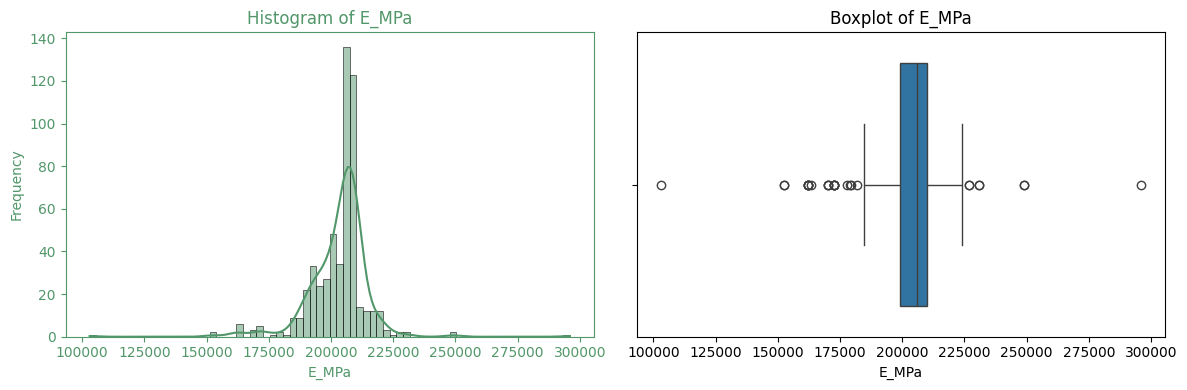


Calculating and Plotting Correlation Matrix...


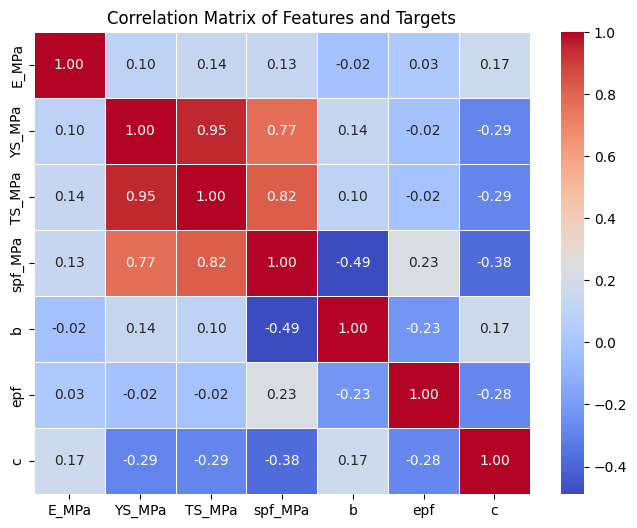


Analysis of target parameters:
Range of 'b': -0.271 -0.015
Range of 'c': -1.863 0.433
Percentage of non-negative 'b': 0.00%
Percentage of non-negative 'c': 0.18%
Percentage where spf_MPa <= TS_MPa: 5.67%

--- Analysis of Log-Transformed epf ---

Descriptive Statistics (Log-Transformed epf):
count    547.000000
mean       0.683633
std        0.984244
min        0.001998
25%        0.266586
50%        0.459953
75%        0.797507
max       12.695830
Name: epf, dtype: float64


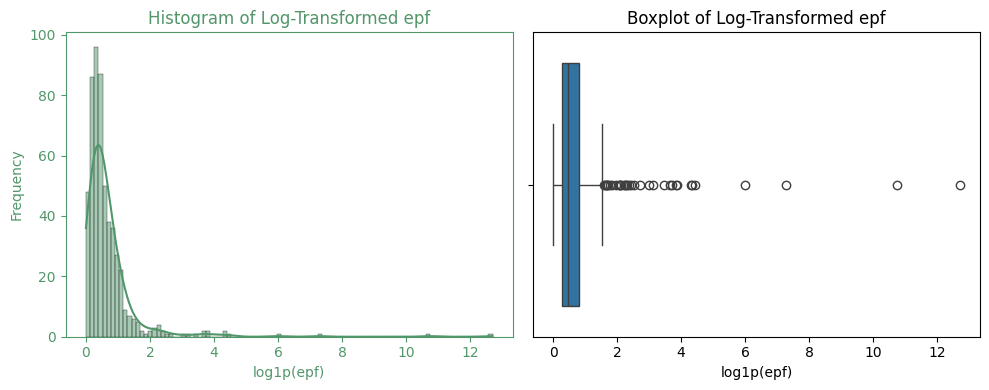

In [21]:
# Cell 5: 탐색적 데이터 분석 (EDA) - 큰 변경 없음, HB_imputed_flag_col 관련 부분 제거

print("\n--- Exploratory Data Analysis ---")

if len(df) > 0: # 데이터가 남아있는 경우에만 EDA 수행
    # 1. Descriptive Statistics
    print("\nDescriptive Statistics (Features and Targets):")
    print(df[feature_cols + target_cols].describe())

    # 2. Distributions
    print("\nPlotting Distributions...")
    n_features = len(feature_cols)
    n_targets = len(target_cols)
    # figure 크기 동적 조절
    fig_height = max(4 * (n_features + n_targets), 12)
    
    # custom color 정의
    custom_color = (82/255, 151/255, 106/255)  # RGB 값
    
    # 첫 번째 컬럼만 그래프로 표시 (성능 향상)
    if len(feature_cols) > 0:
        first_col = feature_cols[0]
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), facecolor='none')
        
        # 1열(히스토그램)에 custom color 적용
        sns.histplot(df[first_col], kde=True, ax=axes[0], color=custom_color)
        axes[0].set_title(f'Histogram of {first_col}', color=custom_color)
        axes[0].set_xlabel(first_col, color=custom_color)
        axes[0].set_ylabel('Frequency', color=custom_color)
        axes[0].tick_params(axis='x', colors=custom_color)
        axes[0].tick_params(axis='y', colors=custom_color)
        axes[0].spines['bottom'].set_color(custom_color)
        axes[0].spines['top'].set_color(custom_color)
        axes[0].spines['left'].set_color(custom_color)
        axes[0].spines['right'].set_color(custom_color)
        axes[0].set_facecolor('none')  # 배경 투명하게 설정
        
        # 2열(박스플롯)은 기본 색상 유지
        sns.boxplot(x=df[first_col], ax=axes[1])
        axes[1].set_title(f'Boxplot of {first_col}')
        axes[1].set_facecolor('none')  # 배경 투명하게 설정

        plt.tight_layout()
        plt.show()

    # 3. Correlation Matrix - 간소화
    print("\nCalculating and Plotting Correlation Matrix...")
    # 상관관계 계산 전, 수치형 데이터만 있는지 확인
    numeric_df_for_corr = df[feature_cols + target_cols].select_dtypes(include=np.number)
    if not numeric_df_for_corr.empty and len(numeric_df_for_corr.columns) > 1:
        correlation_matrix = numeric_df_for_corr.corr()
        plt.figure(figsize=(8, 6), facecolor='none')  # 배경 투명하게 설정
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Features and Targets')
        plt.gca().set_facecolor('none')  # 히트맵 배경 투명하게 설정
        plt.show()
    else:
        print("상관관계 분석을 위한 충분한 수치형 컬럼이 없습니다.")

    # 4. Analysis of Target Parameters (Physical Plausibility)
    print("\nAnalysis of target parameters:")
    if 'b' in df.columns: print("Range of 'b':", df['b'].min(), df['b'].max())
    if 'c' in df.columns: print("Range of 'c':", df['c'].min(), df['c'].max())
    if 'b' in df.columns: print(f"Percentage of non-negative 'b': { (df['b'] >= 0).mean() * 100:.2f}%")
    if 'c' in df.columns: print(f"Percentage of non-negative 'c': { (df['c'] >= 0).mean() * 100:.2f}%")
    if 'spf_MPa' in df.columns and 'TS_MPa' in df.columns:
         print(f"Percentage where spf_MPa <= TS_MPa: { (df['spf_MPa'] <= df['TS_MPa']).mean() * 100:.2f}%")
    
    print("\n--- Analysis of Log-Transformed epf ---")
    if 'epf' in target_cols:
        epf_original_values = df['epf'].copy() # 원본 epf 값 사용 (결측치 제거 후)
        epf_log_transformed = np.log1p(np.maximum(epf_original_values, 1e-10))

        print("\nDescriptive Statistics (Log-Transformed epf):")
        print(pd.Series(epf_log_transformed).describe())

        custom_color = (82/255, 151/255, 106/255)  # RGB 값
        fig, axes = plt.subplots(1, 2, figsize=(10, 4), facecolor='none')
        
        # 히스토그램에 custom color 적용
        sns.histplot(epf_log_transformed, kde=True, ax=axes[0], color=custom_color)
        axes[0].set_title('Histogram of Log-Transformed epf', color=custom_color)
        axes[0].set_xlabel('log1p(epf)', color=custom_color)
        axes[0].set_ylabel('Frequency', color=custom_color)
        axes[0].tick_params(axis='x', colors=custom_color)
        axes[0].tick_params(axis='y', colors=custom_color)
        axes[0].spines['bottom'].set_color(custom_color)
        axes[0].spines['top'].set_color(custom_color)
        axes[0].spines['left'].set_color(custom_color)
        axes[0].spines['right'].set_color(custom_color)
        axes[0].set_facecolor('none')  # 배경 투명하게 설정

        # 박스플롯은 기본 색상 유지
        sns.boxplot(x=epf_log_transformed, ax=axes[1])
        axes[1].set_title('Boxplot of Log-Transformed epf')
        axes[1].set_xlabel('log1p(epf)')
        axes[1].set_facecolor('none')  # 배경 투명하게 설정
        
        plt.tight_layout()
        plt.show()
    else:
        print("epf column not found in target_cols for log-transformed analysis.")

else:
    print("\nNo data available for EDA after preprocessing.")


In [22]:
# Cell 6: 조성 분류 기반 데이터 준비 및 개별 학습 (새로 구현)

print("\n--- Alloy Composition Classification-based Data Preparation for PyTorch ---")

if len(df) > 0:
    # Select final features (X) and targets (y)
    X = df[feature_cols].values
    y = df[target_cols].values
    
    # E_MPa 컬럼이 있는지 확인 후 추출
    if 'E_MPa' in df.columns:
        E_for_loss = df['E_MPa'].values
        print(f"E for loss shape: {E_for_loss.shape}")
    else:
        print("Warning: E_MPa column not found. Cannot extract E for physics loss calculation.")
        E_for_loss = np.zeros(len(df)) # 임시값

    # 조성 분류 정보 추출 (분류 기준)
    if 'alloy_type' in df.columns:
        alloy_classifications = df['alloy_type'].values
        print(f"Features shape (X): {X.shape}")
        print(f"Targets shape (y): {y.shape}")
        print(f"Alloy classifications shape: {alloy_classifications.shape}")

        # === 조성 기준으로 데이터 분류 ===
        unalloyed_mask = alloy_classifications == 'unalloyed'
        lowalloy_mask = alloy_classifications == 'lowalloy'
        highalloy_mask = alloy_classifications == 'highalloy'
        
        print(f"\n--- 조성 기준 데이터 분류 결과 ---")
        print(f"Unalloyed Steel: {np.sum(unalloyed_mask)}개 샘플")
        print(f"Low-alloy Steel: {np.sum(lowalloy_mask)}개 샘플") 
        print(f"High-alloy Steel: {np.sum(highalloy_mask)}개 샘플")
        print(f"총 샘플 수: {len(alloy_classifications)}개")
        
        # 각 그룹별 데이터 분리
        groups = {
            'unalloyed': {'mask': unalloyed_mask, 'name': 'Unalloyed Steel'},
            'lowalloy': {'mask': lowalloy_mask, 'name': 'Low-alloy Steel'},
            'highalloy': {'mask': highalloy_mask, 'name': 'High-alloy Steel'}
        }
    else:
        print("경고: 조성 분류 정보가 없습니다. 모든 데이터를 하나의 그룹으로 처리합니다.")
        # 기본 마스크 (모든 데이터)
        all_mask = np.ones(len(df), dtype=bool)
        groups = {
            'unknown': {'mask': all_mask, 'name': 'Unknown Alloy Type'}
        }
    
    # 각 그룹별로 개별 처리
    for group_name, group_info in groups.items():
        mask = group_info['mask']
        group_display_name = group_info['name']
        
        if np.sum(mask) == 0:
            print(f"\n{group_display_name} 그룹에 데이터가 없어 건너뜁니다.")
            continue
            
        print(f"\n=== {group_display_name} 그룹 처리 시작 ===")
        
        # 그룹 데이터 추출
        X_group = X[mask]
        y_group = y[mask] 
        E_group = E_for_loss[mask]
        
        print(f"그룹 데이터 크기: X={X_group.shape}, y={y_group.shape}, E={E_group.shape}")
        
        # 최소 샘플 수 확인 (train/val/test 분할을 위해)
        if len(X_group) < 10:
            print(f"경고: {group_display_name} 그룹의 샘플 수가 너무 적습니다 ({len(X_group)}개). 건너뜁니다.")
            continue
            
        # 1. Train-Validation-Test Split (그룹별)
        X_train_val_g, X_test_g, y_train_val_g, y_test_g, E_train_val_g, E_test_g = train_test_split(
            X_group, y_group, E_group, test_size=0.15, random_state=seed)
        X_train_g, X_val_g, y_train_g, y_val_g, E_train_g, E_val_g = train_test_split(
            X_train_val_g, y_train_val_g, E_train_val_g, test_size=0.1765, random_state=seed)

        print(f"{group_display_name} - Train: {X_train_g.shape[0]}, Val: {X_val_g.shape[0]}, Test: {X_test_g.shape[0]}")

        # 2. Feature Scaling (그룹별)
        scaler_X_group = StandardScaler()
        X_train_g_scaled = scaler_X_group.fit_transform(X_train_g)
        X_val_g_scaled = scaler_X_group.transform(X_val_g)
        X_test_g_scaled = scaler_X_group.transform(X_test_g)
        
        # Feature scaler 저장
        joblib.dump(scaler_X_group, f'scaler_X_{group_name}.pkl')
        print(f"Feature scaler 저장됨: scaler_X_{group_name}.pkl")

        # 3. Target 변환 및 스케일링 (그룹별)
        target_cols_idx = {name: idx for idx, name in enumerate(target_cols)}
        epf_idx = target_cols_idx.get('epf', -1)

        y_train_g_transformed = y_train_g.copy()
        y_val_g_transformed = y_val_g.copy()
        y_test_g_transformed = y_test_g.copy()

        # epf 로그 변환 (그룹별)
        if epf_idx != -1:
            print(f"{group_display_name} - epf 컬럼에 로그 변환 적용")
            y_train_g_transformed[:, epf_idx] = np.log1p(np.maximum(y_train_g_transformed[:, epf_idx], 1e-10))
            y_val_g_transformed[:, epf_idx] = np.log1p(np.maximum(y_val_g_transformed[:, epf_idx], 1e-10))
            y_test_g_transformed[:, epf_idx] = np.log1p(np.maximum(y_test_g_transformed[:, epf_idx], 1e-10))

        # 타겟별 개별 스케일링 (그룹별)
        scalers_y_group = {}
        y_train_g_scaled = np.zeros_like(y_train_g_transformed)
        y_val_g_scaled = np.zeros_like(y_val_g_transformed)
        y_test_g_scaled = np.zeros_like(y_test_g_transformed)

        for i, col_name in enumerate(target_cols):
            scalers_y_group[col_name] = StandardScaler()
            scalers_y_group[col_name].fit(y_train_g_transformed[:, i].reshape(-1, 1))
            
            y_train_g_scaled[:, i] = scalers_y_group[col_name].transform(y_train_g_transformed[:, i].reshape(-1, 1)).flatten()
            y_val_g_scaled[:, i] = scalers_y_group[col_name].transform(y_val_g_transformed[:, i].reshape(-1, 1)).flatten()
            y_test_g_scaled[:, i] = scalers_y_group[col_name].transform(y_test_g_transformed[:, i].reshape(-1, 1)).flatten()

        # Target scaler와 target_cols 정보 함께 저장
        data_to_save_y_group = {'scalers': scalers_y_group, 'target_cols': target_cols}
        joblib.dump(data_to_save_y_group, f'scaler_y_{group_name}.pkl')
        print(f"Target scaler 저장됨: scaler_y_{group_name}.pkl (target_cols 포함)")

        # 4. PyTorch 데이터 로더 생성 (그룹별)
        batch_size = min(32, len(X_train_g) // 4)  # 그룹 크기에 따라 배치 크기 조정
        
        train_dataset_g = TensorDataset(
            torch.tensor(X_train_g_scaled, dtype=torch.float32),
            torch.tensor(y_train_g_scaled, dtype=torch.float32),
            torch.tensor(E_train_g, dtype=torch.float32)
        )
        val_dataset_g = TensorDataset(
            torch.tensor(X_val_g_scaled, dtype=torch.float32),
            torch.tensor(y_val_g_scaled, dtype=torch.float32),
            torch.tensor(E_val_g, dtype=torch.float32)
        )
        test_dataset_g = TensorDataset(
            torch.tensor(X_test_g_scaled, dtype=torch.float32),
            torch.tensor(y_test_g_scaled, dtype=torch.float32),
            torch.tensor(E_test_g, dtype=torch.float32)
        )

        train_loader_g = DataLoader(train_dataset_g, batch_size=batch_size, shuffle=True)
        val_loader_g = DataLoader(val_dataset_g, batch_size=batch_size, shuffle=False)
        test_loader_g = DataLoader(test_dataset_g, batch_size=batch_size, shuffle=False)
        
        print(f"{group_display_name} - 데이터 로더 생성 완료 (배치 크기: {batch_size})")
        
        # 그룹별 변수를 글로벌 네임스페이스에 저장
        globals()[f'X_train_{group_name}'] = X_train_g
        globals()[f'X_val_{group_name}'] = X_val_g  
        globals()[f'X_test_{group_name}'] = X_test_g
        globals()[f'y_train_{group_name}'] = y_train_g
        globals()[f'y_val_{group_name}'] = y_val_g
        globals()[f'y_test_{group_name}'] = y_test_g
        globals()[f'E_train_{group_name}'] = E_train_g
        globals()[f'E_val_{group_name}'] = E_val_g
        globals()[f'E_test_{group_name}'] = E_test_g
        
        globals()[f'X_train_{group_name}_scaled'] = X_train_g_scaled
        globals()[f'X_val_{group_name}_scaled'] = X_val_g_scaled
        globals()[f'X_test_{group_name}_scaled'] = X_test_g_scaled
        globals()[f'y_train_{group_name}_scaled'] = y_train_g_scaled
        globals()[f'y_val_{group_name}_scaled'] = y_val_g_scaled
        globals()[f'y_test_{group_name}_scaled'] = y_test_g_scaled
        
        globals()[f'scaler_X_{group_name}'] = scaler_X_group
        globals()[f'scalers_y_{group_name}'] = scalers_y_group
        globals()[f'train_loader_{group_name}'] = train_loader_g
        globals()[f'val_loader_{group_name}'] = val_loader_g
        globals()[f'test_loader_{group_name}'] = test_loader_g
        
        print(f"{group_display_name} - 모든 변수 저장 완료")

    print("\n=== 모든 그룹 데이터 준비 완료 ===")
    print("저장된 스케일러 파일:")
    for group_name in ['unalloyed', 'lowalloy', 'highalloy']:
        if f'scaler_X_{group_name}' in globals():
            print(f"  - scaler_X_{group_name}.pkl")
            print(f"  - scaler_y_{group_name}.pkl")

else:
    print("DataFrame이 비어있어 데이터 준비를 건너뜁니다.")



--- Alloy Composition Classification-based Data Preparation for PyTorch ---
E for loss shape: (547,)
Features shape (X): (547, 3)
Targets shape (y): (547, 4)
Alloy classifications shape: (547,)

--- 조성 기준 데이터 분류 결과 ---
Unalloyed Steel: 309개 샘플
Low-alloy Steel: 213개 샘플
High-alloy Steel: 25개 샘플
총 샘플 수: 547개

=== Unalloyed Steel 그룹 처리 시작 ===
그룹 데이터 크기: X=(309, 3), y=(309, 4), E=(309,)
Unalloyed Steel - Train: 215, Val: 47, Test: 47
Feature scaler 저장됨: scaler_X_unalloyed.pkl
Unalloyed Steel - epf 컬럼에 로그 변환 적용
Target scaler 저장됨: scaler_y_unalloyed.pkl (target_cols 포함)
Unalloyed Steel - 데이터 로더 생성 완료 (배치 크기: 32)
Unalloyed Steel - 모든 변수 저장 완료

=== Low-alloy Steel 그룹 처리 시작 ===
그룹 데이터 크기: X=(213, 3), y=(213, 4), E=(213,)
Low-alloy Steel - Train: 149, Val: 32, Test: 32
Feature scaler 저장됨: scaler_X_lowalloy.pkl
Low-alloy Steel - epf 컬럼에 로그 변환 적용
Target scaler 저장됨: scaler_y_lowalloy.pkl (target_cols 포함)
Low-alloy Steel - 데이터 로더 생성 완료 (배치 크기: 32)
Low-alloy Steel - 모든 변수 저장 완료

=== High-alloy Steel 

In [23]:
# PINN Loss Function Definition
def pinn_loss_function(model_outputs_scaled, targets_scaled, E_unscaled,
                       scalers_y_dict, target_cols_list,  # 수정된 부분
                       lambda_physics=0.019082887574579432, num_physics_points=20, 
                       Nf_min=1e1, Nf_max=1e7, device='cpu'):
    """
    Calculates the combined Data and Physics loss for the Fatigue PINN.
    (Function definition remains the same as provided previously)
    """
    # 1. Data Loss (MSE on scaled parameters)
    data_loss_fn = nn.MSELoss()
    
    data_loss_components = []
    epf_loss_weight = 1.0458369452716008  # 옵투나 최적화 결과 적용
                         # 이 값을 조절하며 epf 정확도 변화를 관찰합니다.

    for i, col_name in enumerate(target_cols_list):
        # 각 타겟별로 MSE 손실 계산
        loss_per_target = data_loss_fn(model_outputs_scaled[:, i], targets_scaled[:, i])
        
        if col_name == 'epf':
            data_loss_components.append(epf_loss_weight * loss_per_target)
            print(f"DEBUG: epf_loss (weighted): {epf_loss_weight * loss_per_target.item():.4f}, original_epf_loss: {loss_per_target.item():.4f}") # 디버깅용
        else:
            data_loss_components.append(loss_per_target)
            # print(f"DEBUG: {col_name}_loss: {loss_per_target.item():.4f}") # 다른 타겟 디버깅용 (선택적)

    # 모든 타겟 손실 요소들의 합계를 구함
    data_loss = torch.stack(data_loss_components).sum() 
    # 또는 평균을 사용할 수도 있습니다. sum()이 더 직접적으로 epf 가중치를 반영합니다.
    # data_loss = torch.stack(data_loss_components).mean() 

    # 2. Physics Loss (Coffin-Manson)
    physics_loss = torch.tensor(0.0, device=device) # 기본값 초기화
    try:
        # Inverse transform the *predicted* parameters with our custom function
        batch_size = model_outputs_scaled.shape[0]
        
        # 예측값 역변환
        model_outputs_scaled_np = model_outputs_scaled.detach().cpu().numpy()
        model_outputs_unscaled_np = np.zeros_like(model_outputs_scaled_np)

        for i, col_name in enumerate(target_cols_list):
            model_outputs_unscaled_np[:, i] = scalers_y_dict[col_name].inverse_transform(model_outputs_scaled_np[:, i].reshape(-1, 1)).flatten()

        if 'epf' in target_cols_list:
            epf_idx_dynamic = target_cols_list.index('epf')
            model_outputs_unscaled_np[:, epf_idx_dynamic] = np.expm1(model_outputs_unscaled_np[:, epf_idx_dynamic])

        model_outputs_unscaled = torch.tensor(model_outputs_unscaled_np, dtype=torch.float32).to(device)

        # 동적 인덱스 추출
        spf_pred_idx = target_cols_list.index('spf_MPa')
        b_pred_idx = target_cols_list.index('b')
        epf_pred_idx = target_cols_list.index('epf')
        c_pred_idx = target_cols_list.index('c')

        spf_pred = model_outputs_unscaled[:, spf_pred_idx].unsqueeze(1)
        b_pred = model_outputs_unscaled[:, b_pred_idx].unsqueeze(1)
        epf_pred = model_outputs_unscaled[:, epf_pred_idx].unsqueeze(1)
        c_pred = model_outputs_unscaled[:, c_pred_idx].unsqueeze(1)

        reversals = torch.logspace(torch.log10(torch.tensor(Nf_min)), torch.log10(torch.tensor(Nf_max)), num_physics_points).unsqueeze(0).to(device)

        # Avoid division by zero or invalid E
        E_unscaled_safe = torch.where(E_unscaled <= 0, torch.tensor(1e-6, device=device), E_unscaled)

        epsilon_a_pred = (spf_pred / E_unscaled_safe) * (reversals ** b_pred) + epf_pred * (reversals ** c_pred)

        # 실제값 역변환
        targets_scaled_np = targets_scaled.detach().cpu().numpy()
        targets_unscaled_np = np.zeros_like(targets_scaled_np)

        for i, col_name in enumerate(target_cols_list):
            targets_unscaled_np[:, i] = scalers_y_dict[col_name].inverse_transform(targets_scaled_np[:, i].reshape(-1, 1)).flatten()

        if 'epf' in target_cols_list:
            epf_idx_dynamic = target_cols_list.index('epf')
            targets_unscaled_np[:, epf_idx_dynamic] = np.expm1(targets_unscaled_np[:, epf_idx_dynamic])

        targets_unscaled = torch.tensor(targets_unscaled_np, dtype=torch.float32).to(device)
        
        spf_true = targets_unscaled[:, spf_pred_idx].unsqueeze(1)
        b_true = targets_unscaled[:, b_pred_idx].unsqueeze(1)
        epf_true = targets_unscaled[:, epf_pred_idx].unsqueeze(1)
        c_true = targets_unscaled[:, c_pred_idx].unsqueeze(1)
        
        epsilon_a_true = (spf_true / E_unscaled_safe) * (reversals ** b_true) + epf_true * (reversals ** c_true)

        physics_loss = torch.mean((epsilon_a_pred - epsilon_a_true)**2)

        # Handle potential NaN in physics loss (e.g., from large exponents)
        if torch.isnan(physics_loss):
             physics_loss = torch.tensor(0.0, device=device)

    except KeyError as e:
        print(f"Warning: KeyError in physics loss calculation: {e}. Setting physics loss to 0 for this batch.")
        physics_loss = torch.tensor(0.0, device=device)
    except Exception as e:
        print(f"Warning: Error calculating physics loss: {e}. Setting physics loss to 0 for this batch.")
        physics_loss = torch.tensor(0.0, device=device)

    # 3. Total Loss
    total_loss = data_loss + lambda_physics * physics_loss

    return total_loss, data_loss, physics_loss

print("PINN Loss Function이 정의되었습니다.")


PINN Loss Function이 정의되었습니다.


In [24]:
# Cell 7: 조성 기반 그룹명 전역 설정 (TS 기반 그룹명을 조성 기반으로 교체)

# 조성 기반 그룹명으로 통일
GROUP_NAMES = ['unalloyed', 'lowalloy', 'highalloy']

print("=== 조성 기반 분류 그룹명 설정 ===")
print(f"사용할 그룹명: {GROUP_NAMES}")

# 각 그룹별 데이터가 정상적으로 생성되었는지 확인
for group_name in GROUP_NAMES:
    # 데이터 로더 확인
    train_loader_var = f'train_loader_{group_name}'
    val_loader_var = f'val_loader_{group_name}'
    scalers_y_var = f'scalers_y_{group_name}'
    
    print(f"\n{group_name} 그룹:")
    print(f"  - {train_loader_var}: {'존재' if train_loader_var in globals() else '없음'}")
    print(f"  - {val_loader_var}: {'존재' if val_loader_var in globals() else '없음'}")
    print(f"  - {scalers_y_var}: {'존재' if scalers_y_var in globals() else '없음'}")

print("\n조성 기반 분류 설정 완료. 이후 Cell들에서 GROUP_NAMES를 사용하세요.")


=== 조성 기반 분류 그룹명 설정 ===
사용할 그룹명: ['unalloyed', 'lowalloy', 'highalloy']

unalloyed 그룹:
  - train_loader_unalloyed: 존재
  - val_loader_unalloyed: 존재
  - scalers_y_unalloyed: 존재

lowalloy 그룹:
  - train_loader_lowalloy: 존재
  - val_loader_lowalloy: 존재
  - scalers_y_lowalloy: 존재

highalloy 그룹:
  - train_loader_highalloy: 존재
  - val_loader_highalloy: 존재
  - scalers_y_highalloy: 존재

조성 기반 분류 설정 완료. 이후 Cell들에서 GROUP_NAMES를 사용하세요.


In [25]:
# Cell 9: PINN 모델 정의 (FatiguePINN) - 조성 기반 분류용

print("=== PINN 모델 정의 (조성 기반 분류용) ===")

class FatiguePINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[192, 384, 352, 224], dropout_p=0.35): 
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # 신경망 레이어 구성
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_p))
            prev_dim = hidden_dim
        
        # 출력 레이어
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
        
        # 가중치 초기화
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        return self.network(x)

print("FatiguePINN 모델 클래스 정의 완료")

# 손실 함수 정의
def compute_physics_loss(predictions, E_values, lambda_physics=0.019082887574579432):
    """
    물리학 기반 손실 함수 (EPF 관계식 기반)
    """
    if predictions.shape[1] >= 4:  # spf, b, epf, c 순서 확인
        spf_pred = predictions[:, 0]  # σ'f
        b_pred = predictions[:, 1]    # b
        epf_pred = predictions[:, 2]  # ε'f (로그 변환된 상태)
        c_pred = predictions[:, 3]    # c
        
        # EPF 관계식: ε'f = (σ'f / E) * (2N)^(b-c)
        # 로그 변환된 epf를 원래 스케일로 복원
        epf_original = torch.expm1(epf_pred)  # log1p의 역변환
        
        # 물리학 제약: EPF 관계가 성립해야 함
        N_ref = 1e6  # 참조 사이클 수
        expected_epf = (spf_pred / E_values) * torch.pow(2 * N_ref, b_pred - c_pred)
        
        physics_loss = torch.mean((epf_original - expected_epf) ** 2)
        
        return lambda_physics * physics_loss
    else:
        return torch.tensor(0.0, device=predictions.device)

print("손실 함수 정의 완료")


=== PINN 모델 정의 (조성 기반 분류용) ===
FatiguePINN 모델 클래스 정의 완료
손실 함수 정의 완료



=== 조성 분류 기반 그룹별 개별 모델 학습 시작 ===
하이퍼파라미터: 에폭=200, 학습률=0.001457, Lambda_Physics=0.019083, 조기종료 인내=20
\n=== unalloyed 그룹 모델 학습 시작 ===
unalloyed 그룹 모델 생성 완료: 입력 크기=3, 출력 크기=4
unalloyed 그룹 학습 시작 (최대 에폭: 200, 조기종료: 20)
  unalloyed - 검증 손실 개선, 모델 저장됨
unalloyed - 에폭 [1/200], 학습 손실: 1.1448 (데이터: 1.1447, 물리: 0.0001), 검증 손실: 1.4432 (데이터: 1.4432, 물리: 0.0000)
  unalloyed - 검증 손실 개선, 모델 저장됨
  unalloyed - 검증 손실 개선, 모델 저장됨
  unalloyed - 검증 손실 개선, 모델 저장됨
unalloyed - 에폭 [20/200], 학습 손실: 0.9837 (데이터: 0.9837, 물리: 0.0000), 검증 손실: 1.4416 (데이터: 1.4416, 물리: 0.0000)
  unalloyed - 31번째 에폭에서 조기 종료
unalloyed 그룹 학습 완료 - 최종 검증 손실: 1.4405


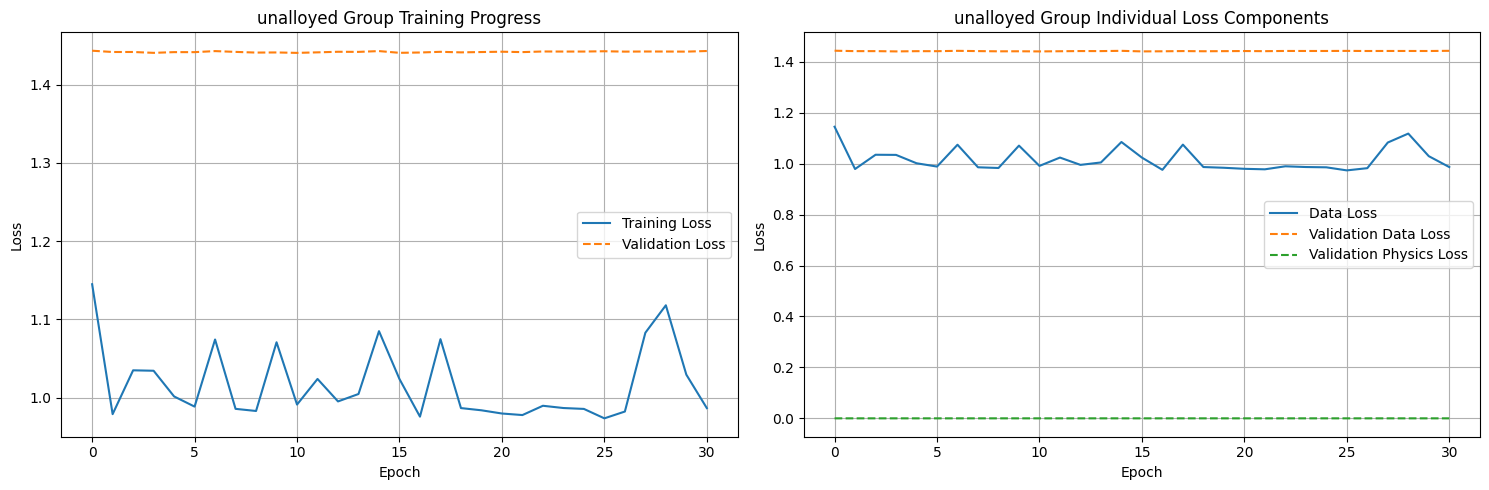

\n=== lowalloy 그룹 모델 학습 시작 ===
lowalloy 그룹 모델 생성 완료: 입력 크기=3, 출력 크기=4
lowalloy 그룹 학습 시작 (최대 에폭: 200, 조기종료: 20)
  lowalloy - 검증 손실 개선, 모델 저장됨
lowalloy - 에폭 [1/200], 학습 손실: 0.9932 (데이터: 0.9932, 물리: 0.0000), 검증 손실: 1.4258 (데이터: 1.4258, 물리: 0.0000)
  lowalloy - 검증 손실 개선, 모델 저장됨
  lowalloy - 검증 손실 개선, 모델 저장됨
  lowalloy - 검증 손실 개선, 모델 저장됨
  lowalloy - 검증 손실 개선, 모델 저장됨
  lowalloy - 검증 손실 개선, 모델 저장됨
lowalloy - 에폭 [20/200], 학습 손실: 0.9898 (데이터: 0.9898, 물리: 0.0000), 검증 손실: 1.4171 (데이터: 1.4171, 물리: 0.0000)
  lowalloy - 30번째 에폭에서 조기 종료
lowalloy 그룹 학습 완료 - 최종 검증 손실: 1.4115


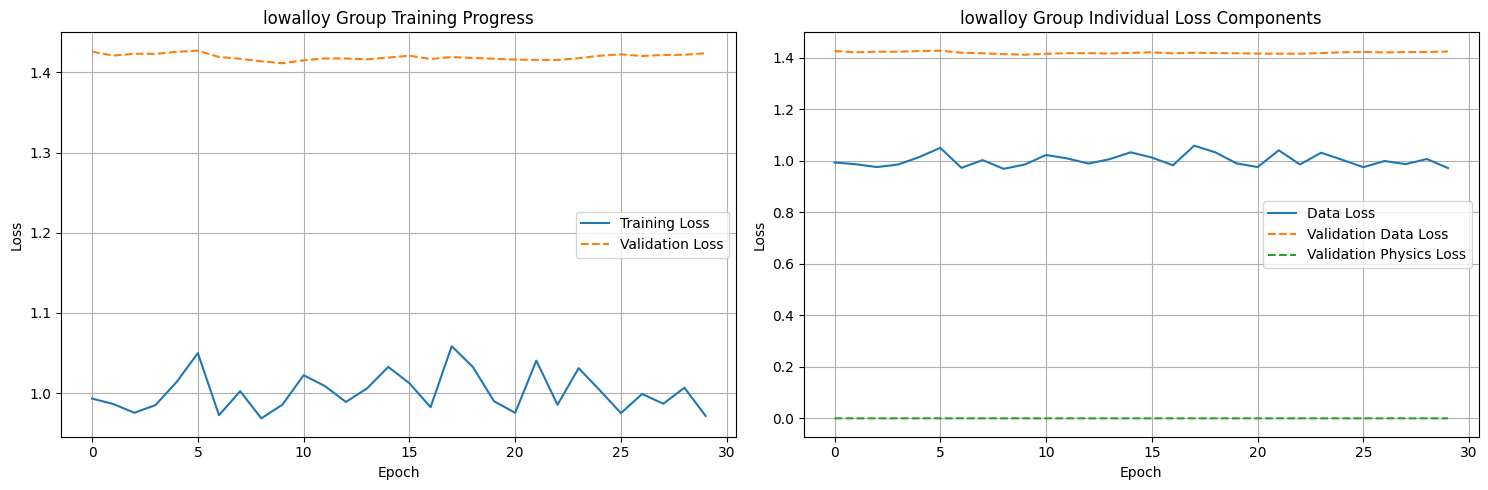

\n=== highalloy 그룹 모델 학습 시작 ===
highalloy 그룹 모델 생성 완료: 입력 크기=3, 출력 크기=4
highalloy 그룹 학습 시작 (최대 에폭: 200, 조기종료: 20)
  highalloy - 검증 손실 개선, 모델 저장됨
highalloy - 에폭 [1/200], 학습 손실: 0.8648 (데이터: 0.8646, 물리: 0.0002), 검증 손실: 5.1624 (데이터: 5.1624, 물리: 0.0000)
  highalloy - 검증 손실 개선, 모델 저장됨
  highalloy - 검증 손실 개선, 모델 저장됨
  highalloy - 검증 손실 개선, 모델 저장됨
  highalloy - 검증 손실 개선, 모델 저장됨
highalloy - 에폭 [20/200], 학습 손실: 0.9442 (데이터: 0.9442, 물리: 0.0000), 검증 손실: 5.1732 (데이터: 5.1732, 물리: 0.0000)
  highalloy - 27번째 에폭에서 조기 종료
highalloy 그룹 학습 완료 - 최종 검증 손실: 5.1419


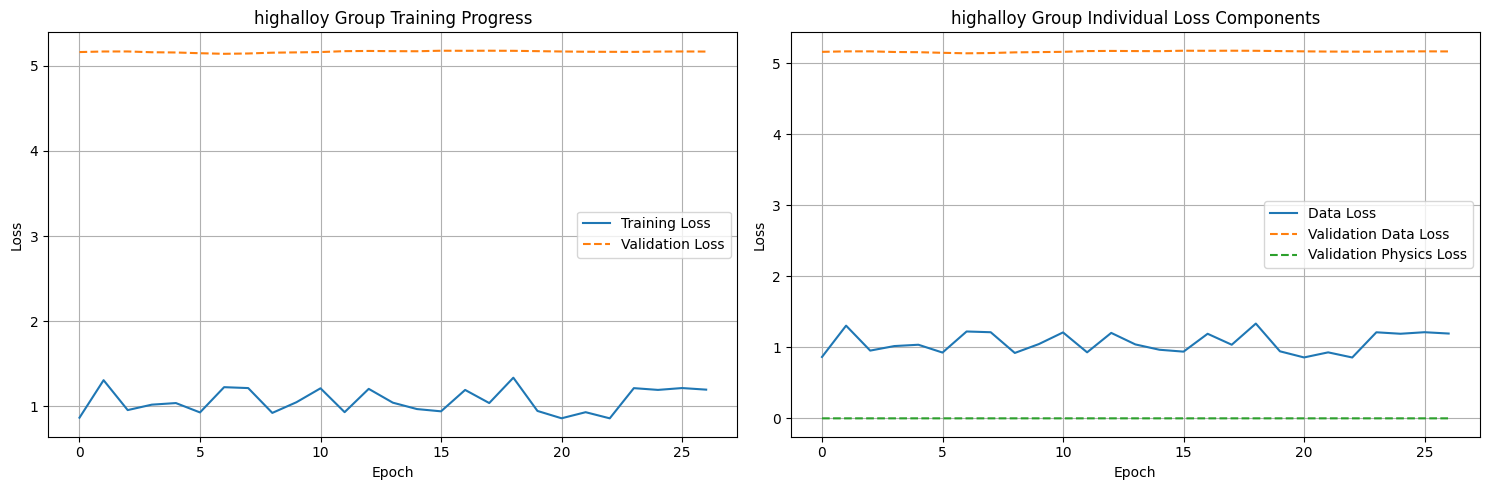

\n=== 모든 조성 그룹의 모델 학습 완료 ===
저장된 모델 파일:
  - model_unalloyed.pth
  - model_lowalloy.pth
  - model_highalloy.pth
\n총 3개 조성 그룹 학습 완료: ['unalloyed', 'lowalloy', 'highalloy']


In [26]:
# Cell 10: 조성 기반 그룹별 모델 학습

if len(df) > 0 and 'alloy_type' in df.columns:
    print("\n=== 조성 분류 기반 그룹별 개별 모델 학습 시작 ===")
    
    # 학습 하이퍼파라미터 (기존 최적화 결과 활용)
    learning_rate = 0.0014568233546356163
    epochs = 200
    patience = 20
    lambda_physics_value = 0.019082887574579432
    
    print(f"하이퍼파라미터: 에폭={epochs}, 학습률={learning_rate:.6f}, Lambda_Physics={lambda_physics_value:.6f}, 조기종료 인내={patience}")
    
    # 모델 관련 전역 변수 설정
    models = {}
    best_val_losses = {}
    trained_groups = []
    
    # 조성 기반 그룹별 모델 학습
    for group_name in GROUP_NAMES:  # ['unalloyed', 'lowalloy', 'highalloy']
        # 해당 그룹의 데이터 로더가 존재하는지 확인
        train_loader_var = f'train_loader_{group_name}'
        val_loader_var = f'val_loader_{group_name}'
        scalers_y_var = f'scalers_y_{group_name}'
        
        if train_loader_var not in globals() or val_loader_var not in globals():
            print(f"\\n{group_name} 그룹: 데이터 로더가 없어 건너뜁니다.")
            continue
            
        train_loader_g = globals()[train_loader_var]
        val_loader_g = globals()[val_loader_var]
        scalers_y_g = globals()[scalers_y_var]
        
        print(f"\\n=== {group_name} 그룹 모델 학습 시작 ===")
        
        # 그룹별 모델 생성
        model_g = FatiguePINN(
            input_dim=len(feature_cols),
            output_dim=len(target_cols),
            hidden_dims=[192, 384, 352, 224],  # 옵투나 최적화 결과 적용
            dropout_p=0.35  # 옵투나 최적화 결과 적용
        ).to(device)
        
        print(f"{group_name} 그룹 모델 생성 완료: 입력 크기={len(feature_cols)}, 출력 크기={len(target_cols)}")
        
        # Optimizer
        optimizer = torch.optim.Adam(model_g.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        
        # 학습 기록용 리스트
        train_losses_g = []
        val_losses_g = []
        train_data_loss_hist_g = []
        val_data_loss_hist_g = []
        val_phys_loss_hist_g = []
        
        best_val_loss_g = float('inf')
        patience_counter = 0
        
        print(f"{group_name} 그룹 학습 시작 (최대 에폭: {epochs}, 조기종료: {patience})")
        
        for epoch in range(epochs):
            # === 학습 단계 ===
            model_g.train()
            total_train_loss = 0
            total_train_data_loss = 0
            
            for batch_X, batch_y, batch_E in train_loader_g:
                batch_X, batch_y, batch_E = batch_X.to(device), batch_y.to(device), batch_E.to(device)
                
                optimizer.zero_grad()
                predictions = model_g(batch_X)
                
                # 데이터 손실
                data_loss = criterion(predictions, batch_y)
                
                # 물리학 손실
                physics_loss = compute_physics_loss(predictions, batch_E, lambda_physics_value)
                
                # 총 손실
                total_loss = data_loss + physics_loss
                total_loss.backward()
                optimizer.step()
                
                total_train_loss += total_loss.item()
                total_train_data_loss += data_loss.item()
            
            avg_train_loss = total_train_loss / len(train_loader_g)
            avg_train_data_loss = total_train_data_loss / len(train_loader_g)
            
            # === 검증 단계 ===
            model_g.eval()
            total_val_loss = 0
            total_val_data_loss = 0
            total_val_phys_loss = 0
            
            with torch.no_grad():
                for batch_X, batch_y, batch_E in val_loader_g:
                    batch_X, batch_y, batch_E = batch_X.to(device), batch_y.to(device), batch_E.to(device)
                    
                    predictions = model_g(batch_X)
                    
                    # 데이터 손실
                    data_loss = criterion(predictions, batch_y)
                    
                    # 물리학 손실
                    physics_loss = compute_physics_loss(predictions, batch_E, lambda_physics_value)
                    
                    # 총 손실
                    total_loss = data_loss + physics_loss
                    
                    total_val_loss += total_loss.item()
                    total_val_data_loss += data_loss.item()
                    total_val_phys_loss += physics_loss.item()
            
            avg_val_loss = total_val_loss / len(val_loader_g)
            avg_val_data_loss = total_val_data_loss / len(val_loader_g)
            avg_val_phys_loss = total_val_phys_loss / len(val_loader_g)
            
            # 기록 저장
            train_losses_g.append(avg_train_loss)
            val_losses_g.append(avg_val_loss)
            train_data_loss_hist_g.append(avg_train_data_loss)
            val_data_loss_hist_g.append(avg_val_data_loss)
            val_phys_loss_hist_g.append(avg_val_phys_loss)
            
            # 조기 종료 및 모델 저장
            if avg_val_loss < best_val_loss_g:
                best_val_loss_g = avg_val_loss
                torch.save(model_g.state_dict(), f'model_{group_name}.pth')
                patience_counter = 0
                print(f"  {group_name} - 검증 손실 개선, 모델 저장됨")
            else:
                patience_counter += 1
            
            # 에폭 정보 출력 (매 20에폭마다)
            if (epoch + 1) % 20 == 0 or epoch == 0:
                print(f"{group_name} - 에폭 [{epoch + 1}/{epochs}], 학습 손실: {avg_train_loss:.4f} (데이터: {avg_train_data_loss:.4f}, 물리: {avg_train_loss - avg_train_data_loss:.4f}), 검증 손실: {avg_val_loss:.4f} (데이터: {avg_val_data_loss:.4f}, 물리: {avg_val_phys_loss:.4f})")
            
            # 조기 종료
            if patience_counter >= patience:
                print(f"  {group_name} - {epoch + 1}번째 에폭에서 조기 종료")
                break
        
        print(f"{group_name} 그룹 학습 완료 - 최종 검증 손실: {best_val_loss_g:.4f}")
        
        # 그룹별 결과 저장
        models[group_name] = model_g
        best_val_losses[group_name] = best_val_loss_g
        trained_groups.append(group_name)
        
        # 글로벌 변수에 저장
        globals()[f'model_{group_name}'] = model_g
        globals()[f'train_losses_{group_name}'] = train_losses_g
        globals()[f'val_losses_{group_name}'] = val_losses_g
        globals()[f'best_val_loss_{group_name}'] = best_val_loss_g
        
        # 학습 곡선 시각화
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(train_losses_g, label='Training Loss')
        plt.plot(val_losses_g, label='Validation Loss', linestyle='--')
        plt.title(f'{group_name} Group Training Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(train_data_loss_hist_g, label='Data Loss')
        plt.plot(val_data_loss_hist_g, label='Validation Data Loss', linestyle='--')
        plt.plot(val_phys_loss_hist_g, label='Validation Physics Loss', linestyle='--')
        plt.title(f'{group_name} Group Individual Loss Components')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    print("\\n=== 모든 조성 그룹의 모델 학습 완료 ===")
    print("저장된 모델 파일:")
    for group_name in GROUP_NAMES:
        if f'model_{group_name}' in globals():
            print(f"  - model_{group_name}.pth")

    # 그룹별 학습 완료 확인
    if trained_groups:
        print(f"\\n총 {len(trained_groups)}개 조성 그룹 학습 완료: {trained_groups}")
    else:
        print("\\n경고: 어떤 그룹도 학습되지 않았습니다. Cell 6에서 데이터 준비가 제대로 되었는지 확인하세요.")

else:
    print("조성 분류 정보가 없거나 데이터가 없어 그룹별 학습을 건너뜁니다.")


In [27]:
# Cell 11: 조성 기반 그룹별 모델 평가

print("=== 조성 기반 그룹별 모델 평가 ===")

# 평가 함수 정의
def evaluate_model_group(model, test_loader, scalers_y, target_cols, group_name, device):
    """그룹별 모델 평가 함수"""
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y, batch_E in test_loader:
            batch_X = batch_X.to(device)
            predictions = model(batch_X)
            
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(batch_y.numpy())
    
    # 배치들을 연결
    predictions_scaled = np.vstack(all_predictions)
    targets_scaled = np.vstack(all_targets)
    
    print(f"\\n=== {group_name} 그룹 평가 ===")
    print(f"{group_name} - 테스트 샘플 수: {len(predictions_scaled)}")
    
    # 스케일링 해제
    predictions_orig = np.zeros_like(predictions_scaled)
    targets_orig = np.zeros_like(targets_scaled)
    
    for i, col_name in enumerate(target_cols):
        # 예측값 스케일링 해제
        pred_unscaled = scalers_y[col_name].inverse_transform(predictions_scaled[:, i].reshape(-1, 1)).flatten()
        target_unscaled = scalers_y[col_name].inverse_transform(targets_scaled[:, i].reshape(-1, 1)).flatten()
        
        # epf의 경우 로그 변환 해제
        if col_name == 'epf':
            pred_unscaled = np.expm1(pred_unscaled)  # log1p의 역변환
            target_unscaled = np.expm1(target_unscaled)
            print(f"{group_name} - epf 로그 변환 해제 완료")
        
        predictions_orig[:, i] = pred_unscaled
        targets_orig[:, i] = target_unscaled
    
    # 성능 평가
    print(f"\\n{group_name} 그룹 성능 평가:")
    for i, col_name in enumerate(target_cols):
        mse = mean_squared_error(targets_orig[:, i], predictions_orig[:, i])
        r2 = r2_score(targets_orig[:, i], predictions_orig[:, i])
        print(f"  {col_name}: MSE={mse:.6f}, R²={r2:.4f}")
    
    return predictions_orig, targets_orig

# 각 그룹별 평가 수행
evaluation_results = {}

for group_name in GROUP_NAMES:
    model_var = f'model_{group_name}'
    test_loader_var = f'test_loader_{group_name}'
    scalers_y_var = f'scalers_y_{group_name}'
    
    if all(var in globals() for var in [model_var, test_loader_var, scalers_y_var]):
        model_g = globals()[model_var]
        test_loader_g = globals()[test_loader_var]
        scalers_y_g = globals()[scalers_y_var]
        
        # 모델 평가
        predictions_orig, targets_orig = evaluate_model_group(
            model_g, test_loader_g, scalers_y_g, target_cols, group_name, device
        )
        
        # 결과 저장
        evaluation_results[group_name] = {
            'predictions': predictions_orig,
            'targets': targets_orig
        }
        
        # 글로벌 변수에도 저장
        globals()[f'all_preds_orig_{group_name}'] = predictions_orig
        globals()[f'all_targets_orig_{group_name}'] = targets_orig
        
    else:
        print(f"\\n{group_name} 그룹: 필요한 변수들이 없어 평가를 건너뜁니다.")

print("\\n=== 모든 그룹 평가 완료 ===")

# 대표 그룹 설정 (GUI나 다른 Cell에서 사용하기 위해)
if evaluation_results:
    representative_group = list(evaluation_results.keys())[0]  # 첫 번째 그룹을 대표로 설정
    print(f"\\n대표 그룹 설정:")
    print(f"- model: {representative_group} 그룹 모델을 대표 모델로 설정")
    print(f"- scaler_X: {representative_group} 그룹 Feature 스케일러를 대표 스케일러로 설정")
    print(f"- scalers_y: {representative_group} 그룹 Target 스케일러를 대표 스케일러로 설정")
    
    # 대표 변수들 설정
    globals()['model'] = globals()[f'model_{representative_group}']
    globals()['scaler_X'] = globals()[f'scaler_X_{representative_group}']
    globals()['scalers_y'] = globals()[f'scalers_y_{representative_group}']
    
    # 통합 결과 변수 설정 (기존 코드 호환성을 위해)
    if f'all_preds_orig_{representative_group}' in globals():
        globals()['all_preds_orig'] = globals()[f'all_preds_orig_{representative_group}']
        globals()['all_targets_orig'] = globals()[f'all_targets_orig_{representative_group}']
        
        # E 값도 대표 그룹에서 가져오기
        if f'E_test_{representative_group}' in globals():
            globals()['E_test'] = globals()[f'E_test_{representative_group}']
        
        print(f"\\n통합 결과 변수 설정 완료 (기존 코드 호환성)")

print("\\n조성 기반 그룹별 평가 완료")


=== 조성 기반 그룹별 모델 평가 ===
\n=== unalloyed 그룹 평가 ===
unalloyed - 테스트 샘플 수: 47
unalloyed - epf 로그 변환 해제 완료
\nunalloyed 그룹 성능 평가:
  spf_MPa: MSE=624794.437500, R²=-0.0127
  b: MSE=0.001289, R²=-0.0081
  epf: MSE=44285.335938, R²=-0.0242
  c: MSE=0.060433, R²=-0.0006
\n=== lowalloy 그룹 평가 ===
lowalloy - 테스트 샘플 수: 32
lowalloy - epf 로그 변환 해제 완료
\nlowalloy 그룹 성능 평가:
  spf_MPa: MSE=441185.875000, R²=-0.0089
  b: MSE=0.001034, R²=-0.1400
  epf: MSE=47.699726, R²=-0.0333
  c: MSE=0.050939, R²=-0.0006
\n=== highalloy 그룹 평가 ===
highalloy - 테스트 샘플 수: 4
highalloy - epf 로그 변환 해제 완료
\nhighalloy 그룹 성능 평가:
  spf_MPa: MSE=105148.671875, R²=-2.8157
  b: MSE=0.000186, R²=-0.7519
  epf: MSE=0.636092, R²=-0.1279
  c: MSE=0.022433, R²=-0.0492
\n=== 모든 그룹 평가 완료 ===
\n대표 그룹 설정:
- model: unalloyed 그룹 모델을 대표 모델로 설정
- scaler_X: unalloyed 그룹 Feature 스케일러를 대표 스케일러로 설정
- scalers_y: unalloyed 그룹 Target 스케일러를 대표 스케일러로 설정
\n통합 결과 변수 설정 완료 (기존 코드 호환성)
\n조성 기반 그룹별 평가 완료


=== 조성 기반 그룹별 성능 비교 시각화 ===


/var/folders/8w/3krsjjds797bmd_c1mcxqq1c0000gn/T/ipykernel_71371/3514303409.py:55: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


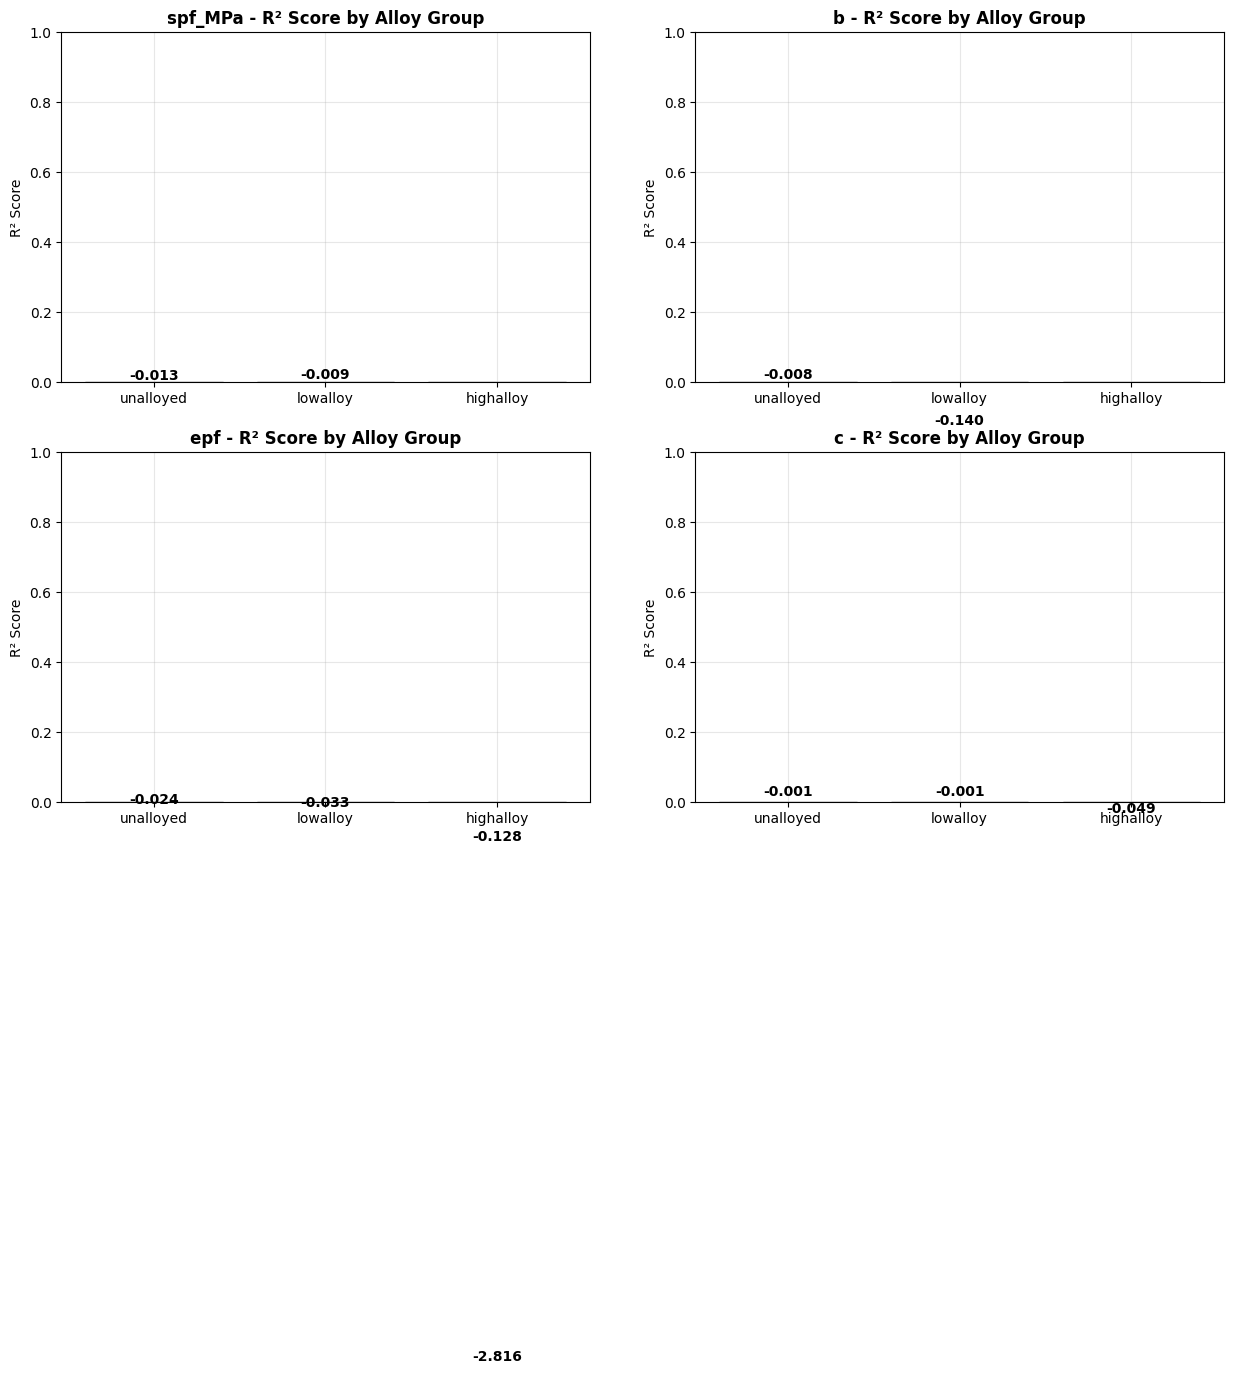

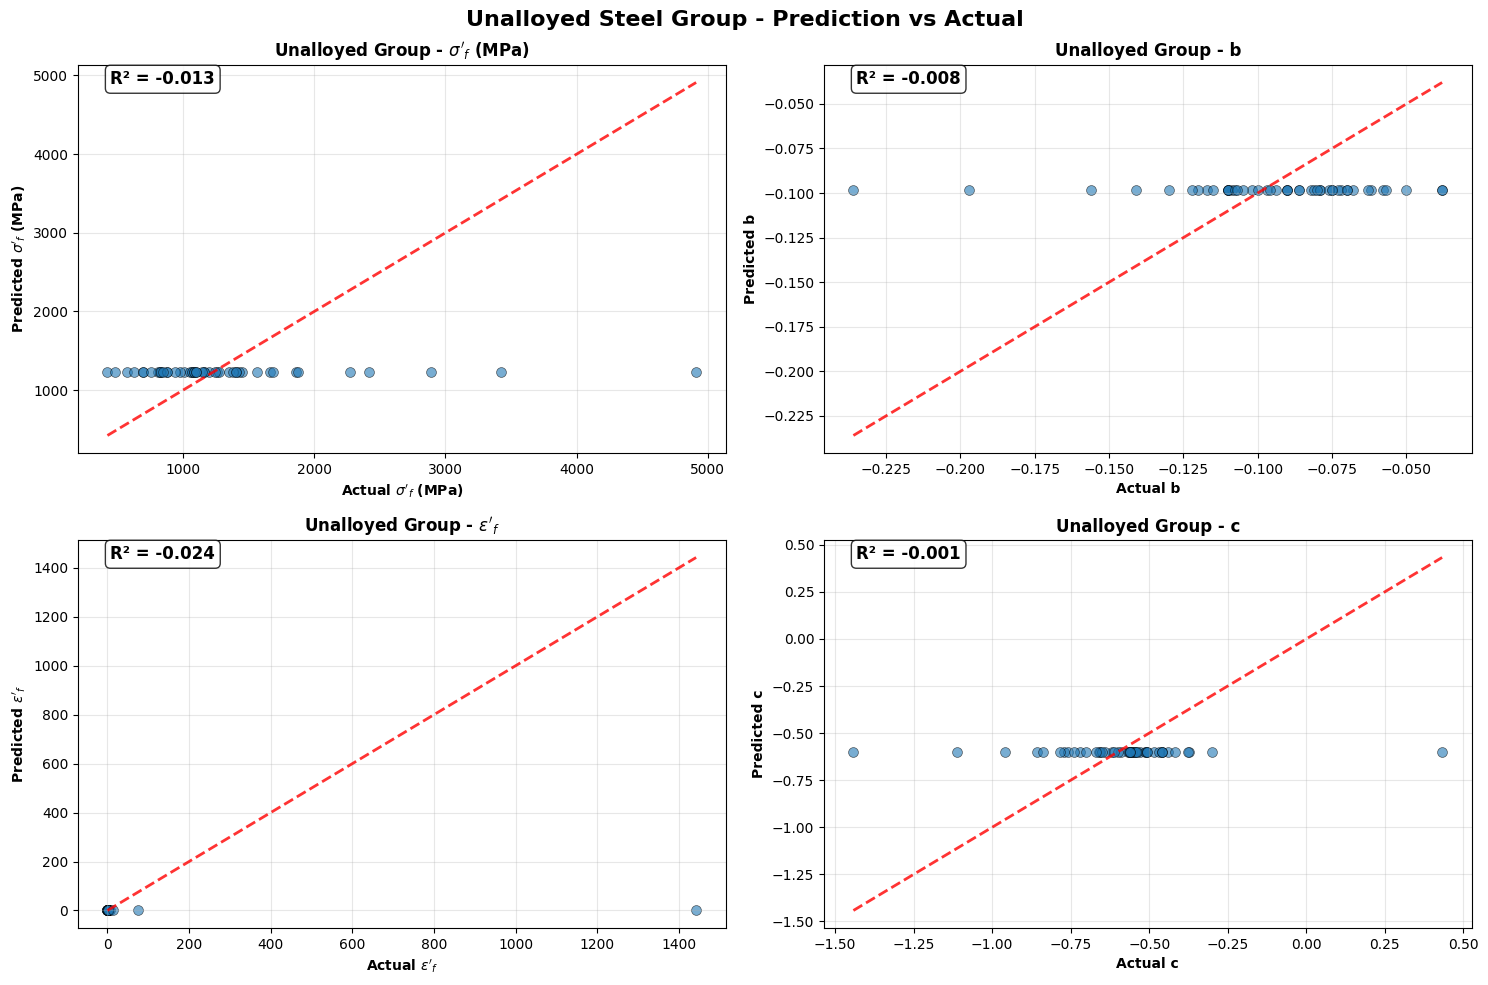

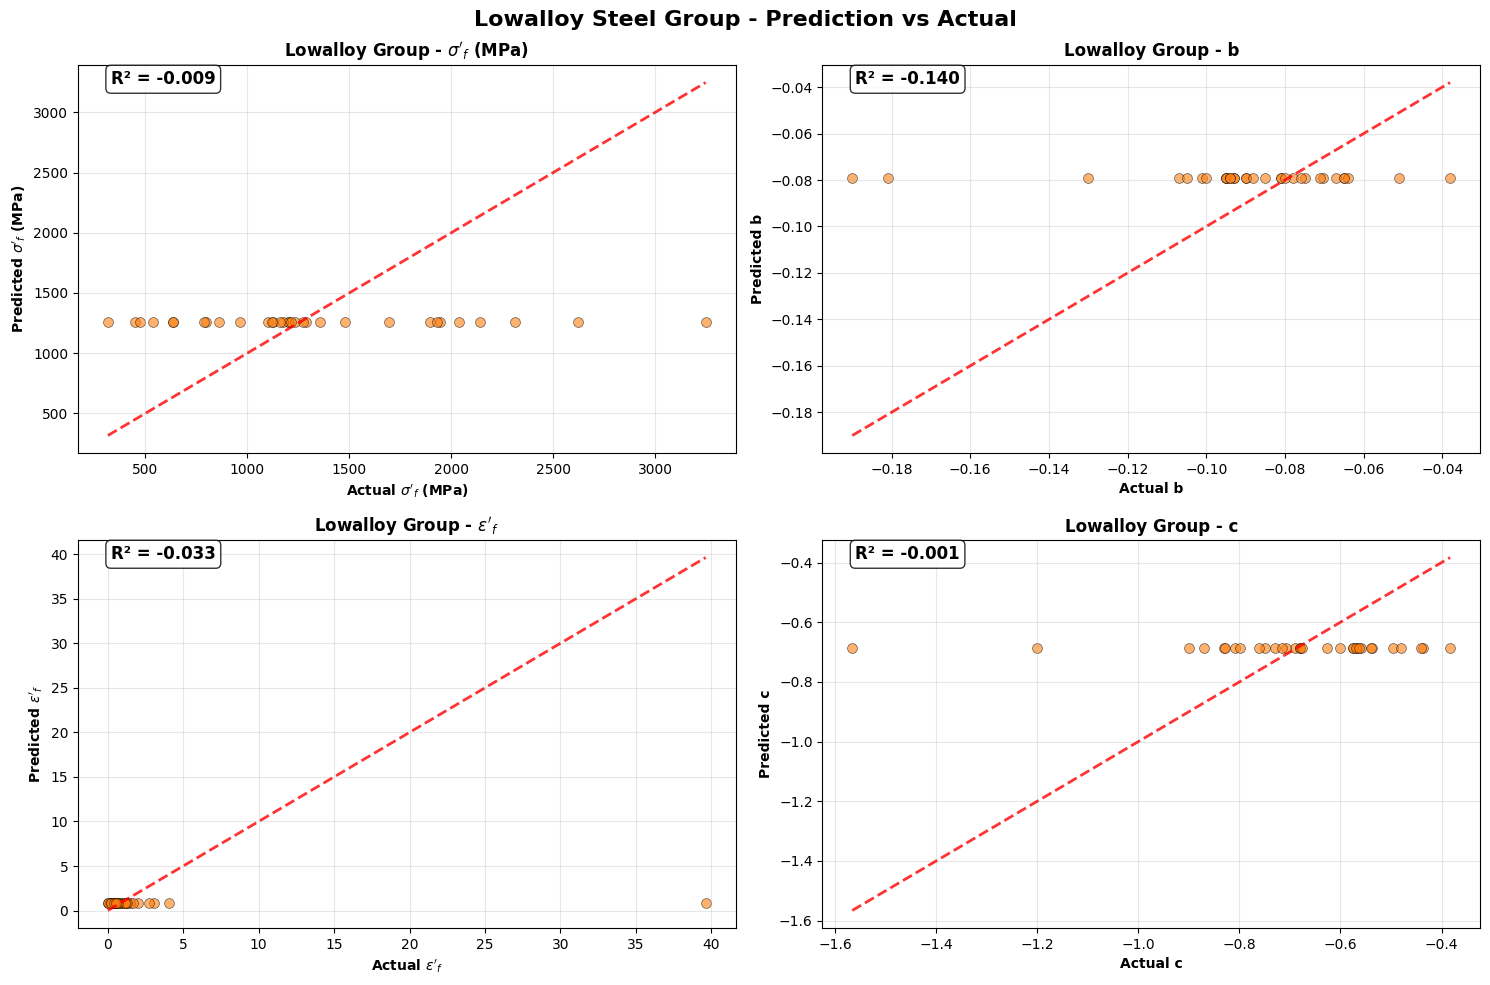

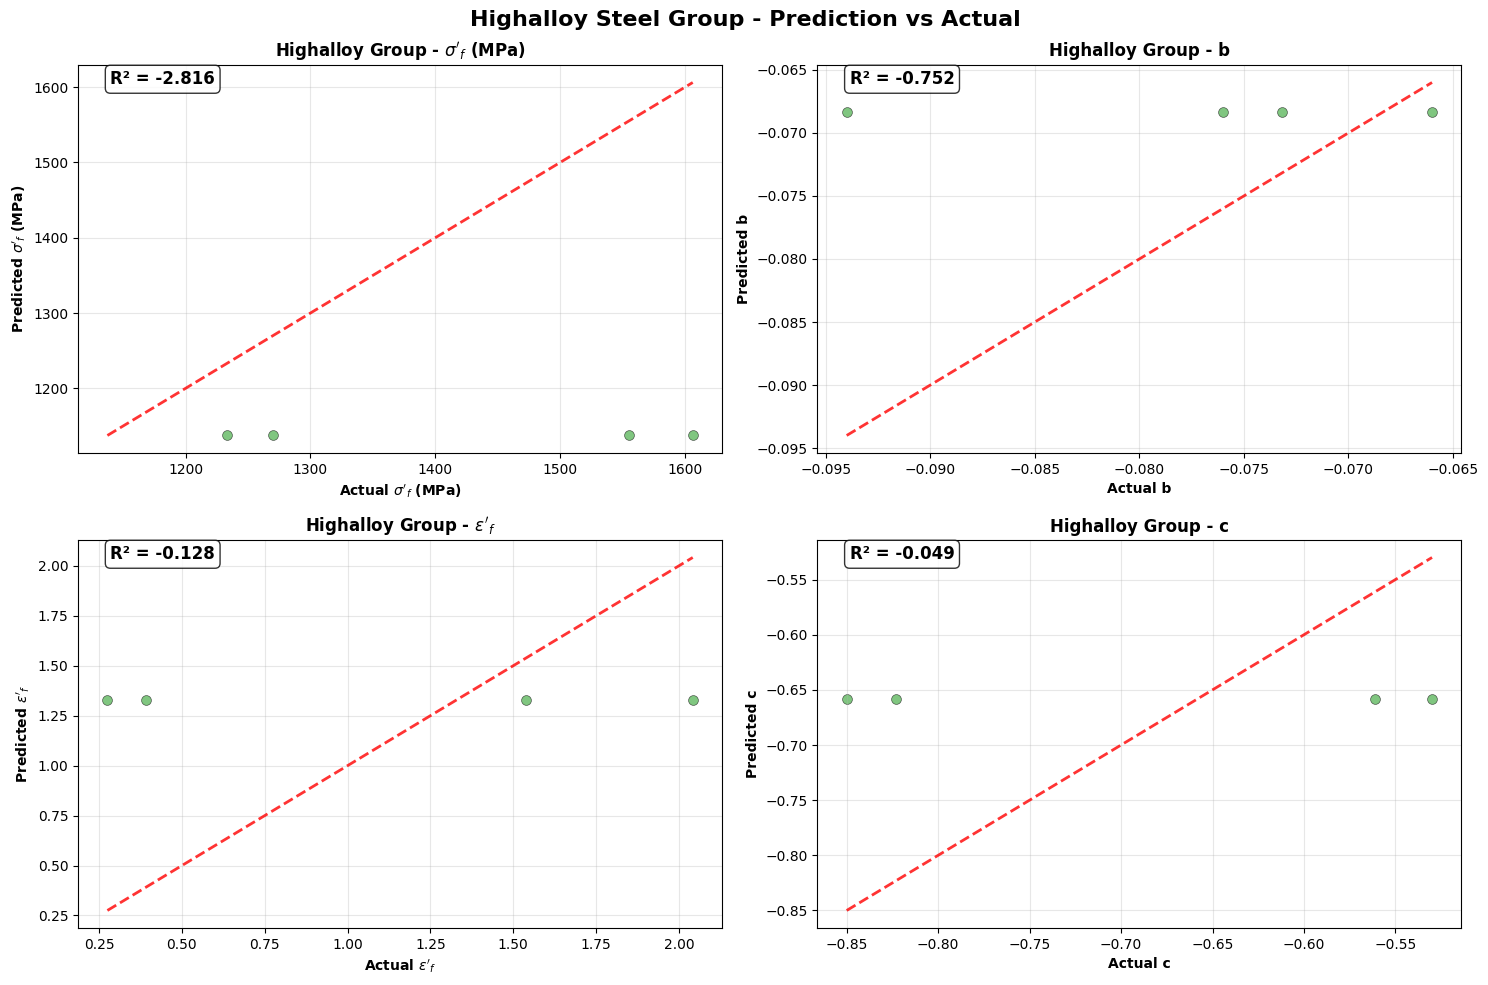


=== 조성 기반 그룹별 성능 요약 ===

Unalloyed Steel Group:
  spf_MPa: R²=-0.0127, MSE=624794.437500
  b: R²=-0.0081, MSE=0.001289
  epf: R²=-0.0242, MSE=44285.335938
  c: R²=-0.0006, MSE=0.060433

Lowalloy Steel Group:
  spf_MPa: R²=-0.0089, MSE=441185.875000
  b: R²=-0.1400, MSE=0.001034
  epf: R²=-0.0333, MSE=47.699726
  c: R²=-0.0006, MSE=0.050939

Highalloy Steel Group:
  spf_MPa: R²=-2.8157, MSE=105148.671875
  b: R²=-0.7519, MSE=0.000186
  epf: R²=-0.1279, MSE=0.636092
  c: R²=-0.0492, MSE=0.022433

조성 기반 그룹별 성능 비교 시각화 완료


In [28]:
# Cell 12: 조성 기반 그룹별 성능 비교 시각화

print("=== 조성 기반 그룹별 성능 비교 시각화 ===")

if evaluation_results:
    # 그룹별 색상 정의
    group_colors = {
        'unalloyed': '#1f77b4',   # 파란색
        'lowalloy': '#ff7f0e',    # 주황색  
        'highalloy': '#2ca02c'    # 녹색
    }
    
    # 그룹별 R² 값 수집
    group_r2_data = {group: {param: [] for param in target_cols} for group in GROUP_NAMES}
    
    for group_name in GROUP_NAMES:
        if group_name in evaluation_results:
            predictions = evaluation_results[group_name]['predictions']
            targets = evaluation_results[group_name]['targets']
            
            for i, col_name in enumerate(target_cols):
                r2 = r2_score(targets[:, i], predictions[:, i])
                group_r2_data[group_name][col_name].append(r2)

    # R² 점수 비교 bar plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, param in enumerate(target_cols):
        ax = axes[i]
        
        groups = []
        r2_values = []
        colors = []
        
        for group in GROUP_NAMES:
            if group in evaluation_results and group_r2_data[group][param]:
                groups.append(group)
                r2_values.append(group_r2_data[group][param][0])
                colors.append(group_colors.get(group, '#cccccc'))
        
        if groups:  # 데이터가 있는 경우에만 플롯
            bars = ax.bar(groups, r2_values, color=colors, alpha=0.7, edgecolor='black')
            ax.set_title(f'{param} - R² Score by Alloy Group', fontweight='bold')
            ax.set_ylabel('R² Score')
            ax.set_ylim(0, 1)
            ax.grid(True, alpha=0.3)
            
            # 값 표시
            for bar, r2_val in zip(bars, r2_values):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{r2_val:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # 그룹별 예측 vs 실제값 scatter plot
    for group_name in GROUP_NAMES:
        if group_name in evaluation_results:
            predictions = evaluation_results[group_name]['predictions'] 
            targets = evaluation_results[group_name]['targets']
            
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            axes = axes.flatten()
            
            for i, param in enumerate(target_cols):
                ax = axes[i]
                
                # 단위 설정
                if param == 'spf_MPa':
                    param_label = r"$\sigma'_f$ (MPa)"
                elif param == 'b':
                    param_label = 'b'
                elif param == 'epf':
                    param_label = r"$\varepsilon'_f$"
                elif param == 'c':
                    param_label = 'c'
                else:
                    param_label = param
                
                color = group_colors.get(group_name, '#cccccc')
                
                ax.scatter(targets[:, i], predictions[:, i], 
                          alpha=0.6, color=color, s=50, edgecolors='black', linewidth=0.5)
                
                # 대각선 (perfect prediction line)
                min_val = min(targets[:, i].min(), predictions[:, i].min())
                max_val = max(targets[:, i].max(), predictions[:, i].max())
                ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.8)
                
                ax.set_xlabel(f'Actual {param_label}', fontweight='bold')
                ax.set_ylabel(f'Predicted {param_label}', fontweight='bold')
                ax.set_title(f'{group_name.capitalize()} Group - {param_label}', fontweight='bold')
                ax.grid(True, alpha=0.3)
                
                # R² 표시
                r2 = r2_score(targets[:, i], predictions[:, i])
                ax.text(0.05, 0.95, f'R² = {r2:.3f}', 
                       transform=ax.transAxes, fontsize=12, fontweight='bold',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            plt.suptitle(f'{group_name.capitalize()} Steel Group - Prediction vs Actual', 
                        fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()

    # 전체 그룹 통합 성능 요약
    print("\n=== 조성 기반 그룹별 성능 요약 ===")
    for group_name in GROUP_NAMES:
        if group_name in evaluation_results:
            print(f"\n{group_name.capitalize()} Steel Group:")
            predictions = evaluation_results[group_name]['predictions']
            targets = evaluation_results[group_name]['targets']
            
            for i, param in enumerate(target_cols):
                r2 = r2_score(targets[:, i], predictions[:, i])
                mse = mean_squared_error(targets[:, i], predictions[:, i])
                print(f"  {param}: R²={r2:.4f}, MSE={mse:.6f}")

else:
    print("평가 결과가 없습니다. Cell 11에서 평가를 먼저 수행하세요.")

print("\n조성 기반 그룹별 성능 비교 시각화 완료")


In [29]:
# Cell 13: 결과 요약 및 생성된 파일 목록

print("=== ISO 4948 기준 조성 분류 결과 요약 ===")

print("\\n## 분류 방법")
print("- **Unalloyed Steel (무합금강)**: Mn≤1.65%, Si≤0.60%, Cu≤0.60%, 기타 합금원소≤0.40%")
print("- **Low-alloy Steel (저합금강)**: 총 합금원소 함량 2.07% 초과 ~ 5% 미만")  
print("- **High-alloy Steel (고합금강)**: 총 합금원소 함량 5% 이상")

print("\\n## 생성된 파일 목록")

# Feature Scalers
print("\\n### Feature Scalers:")
for group_name in GROUP_NAMES:
    filename = f"scaler_X_{group_name}.pkl"
    if os.path.exists(filename):
        print(f"  ✓ {filename}")
    else:
        print(f"  ✗ {filename} (생성되지 않음)")

# Target Scalers  
print("\\n### Target Scalers (target_cols 정보 포함):")
for group_name in GROUP_NAMES:
    filename = f"scaler_y_{group_name}.pkl"
    if os.path.exists(filename):
        print(f"  ✓ {filename}")
    else:
        print(f"  ✗ {filename} (생성되지 않음)")

# Models
print("\\n### 학습된 모델:")
for group_name in GROUP_NAMES:
    filename = f"model_{group_name}.pth"
    if os.path.exists(filename):
        print(f"  ✓ {filename}")
    else:
        print(f"  ✗ {filename} (생성되지 않음)")

print("\\n## 사용 방법")
print("각 그룹별로 독립적인 스케일러와 모델이 생성되었습니다.")
print("새로운 데이터 예측 시:")
print("1. 먼저 조성을 분석하여 해당 그룹(unalloyed/lowalloy/highalloy) 결정")
print("2. 해당 그룹의 scaler_X_{group_name}.pkl로 특성 스케일링")
print("3. 해당 그룹의 model_{group_name}.pth로 예측 수행")
print("4. 해당 그룹의 scaler_y_{group_name}.pkl로 결과 역변환")

# 그룹별 학습 결과 요약
print("\\n## 학습 결과 요약")
for group_name in GROUP_NAMES:
    if f'model_{group_name}' in globals():
        best_val_loss_var = f'best_val_loss_{group_name}'
        if best_val_loss_var in globals():
            best_loss = globals()[best_val_loss_var]
            print(f"- {group_name.capitalize()} Steel: 최종 검증 손실 = {best_loss:.4f}")
        else:
            print(f"- {group_name.capitalize()} Steel: 학습 완료")
    else:
        print(f"- {group_name.capitalize()} Steel: 학습되지 않음")

print("\\n=== 조성 기반 분류 처리 완료 ===")
print("\\n참고: 모든 TS 기반 분류는 제거되었으며, ISO 4948 기준 조성 분류만 사용됩니다.")
print("그룹명: unalloyed, lowalloy, highalloy")


=== ISO 4948 기준 조성 분류 결과 요약 ===
\n## 분류 방법
- **Unalloyed Steel (무합금강)**: Mn≤1.65%, Si≤0.60%, Cu≤0.60%, 기타 합금원소≤0.40%
- **Low-alloy Steel (저합금강)**: 총 합금원소 함량 2.07% 초과 ~ 5% 미만
- **High-alloy Steel (고합금강)**: 총 합금원소 함량 5% 이상
\n## 생성된 파일 목록
\n### Feature Scalers:
  ✓ scaler_X_unalloyed.pkl
  ✓ scaler_X_lowalloy.pkl
  ✓ scaler_X_highalloy.pkl
\n### Target Scalers (target_cols 정보 포함):
  ✓ scaler_y_unalloyed.pkl
  ✓ scaler_y_lowalloy.pkl
  ✓ scaler_y_highalloy.pkl
\n### 학습된 모델:
  ✓ model_unalloyed.pth
  ✓ model_lowalloy.pth
  ✓ model_highalloy.pth
\n## 사용 방법
각 그룹별로 독립적인 스케일러와 모델이 생성되었습니다.
새로운 데이터 예측 시:
1. 먼저 조성을 분석하여 해당 그룹(unalloyed/lowalloy/highalloy) 결정
2. 해당 그룹의 scaler_X_{group_name}.pkl로 특성 스케일링
3. 해당 그룹의 model_{group_name}.pth로 예측 수행
4. 해당 그룹의 scaler_y_{group_name}.pkl로 결과 역변환
\n## 학습 결과 요약
- Unalloyed Steel: 최종 검증 손실 = 1.4405
- Lowalloy Steel: 최종 검증 손실 = 1.4115
- Highalloy Steel: 최종 검증 손실 = 5.1419
\n=== 조성 기반 분류 처리 완료 ===
\n참고: 모든 TS 기반 분류는 제거되었으며, ISO 4948 기준 조성 분류만 사용됩니다.
그룹명: unalloye

=== E-N 및 Gamma-N 곡선 생성 함수 (조성 기반) ===
\n조성 기반 그룹별 E-N 곡선 생성:


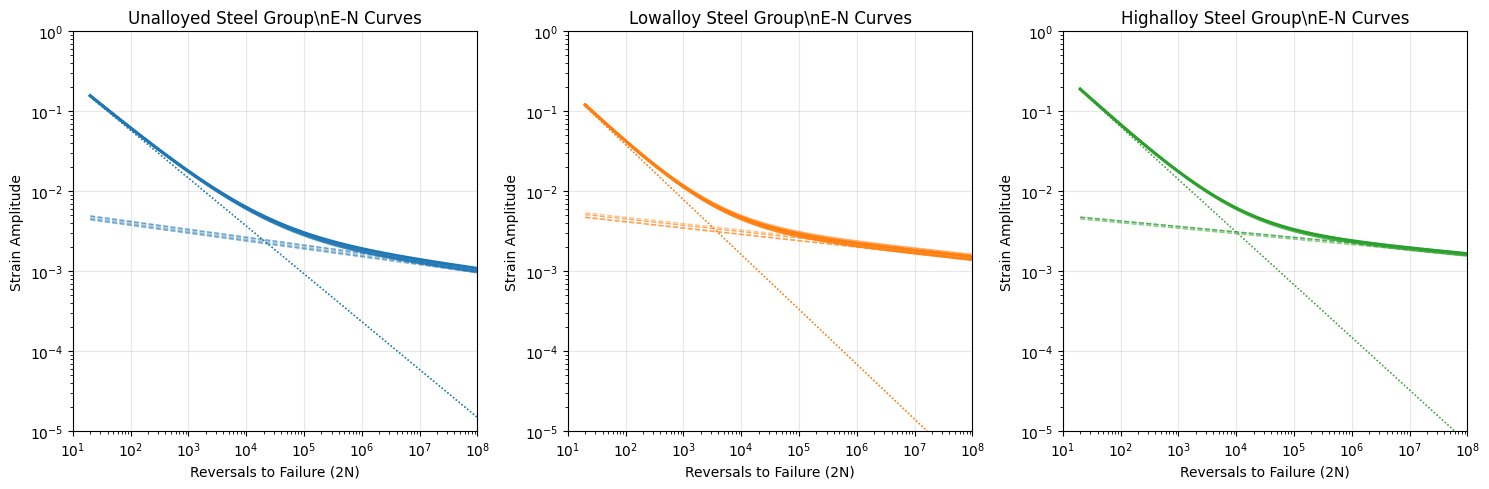

\n조성 기반 그룹별 Gamma-N 곡선 생성:


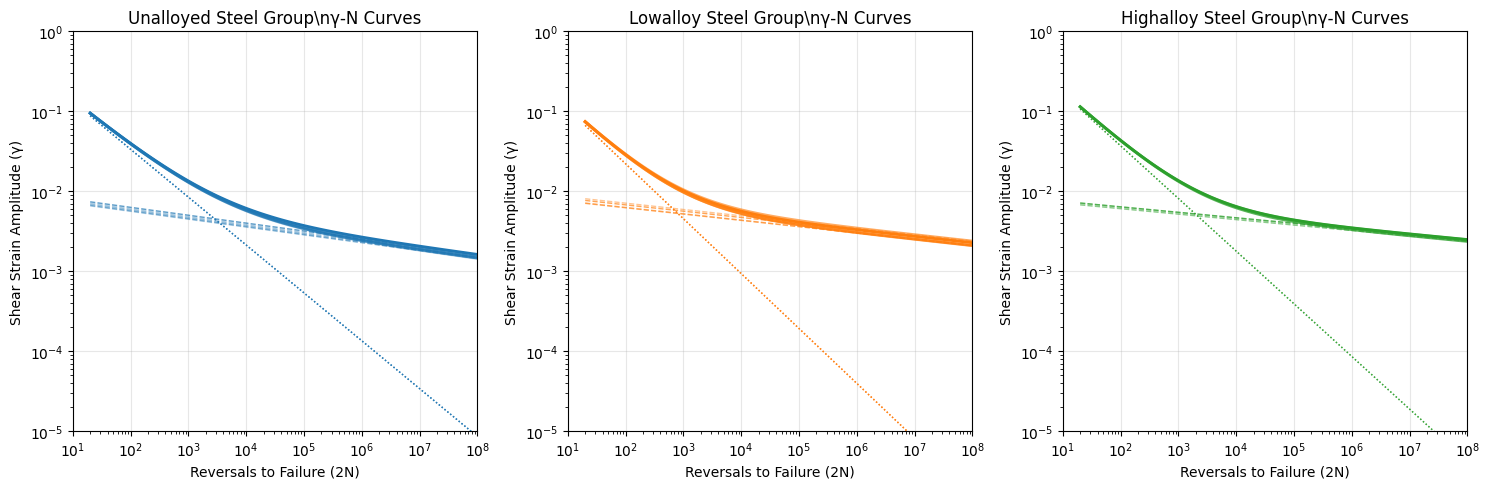

\n조성 기반 E-N 및 Gamma-N 곡선 생성 완료


In [30]:
# Cell 14: E-N 및 Gamma-N 곡선 생성 함수 (조성 기반)

print("=== E-N 및 Gamma-N 곡선 생성 함수 (조성 기반) ===")

def plot_en_curves_by_alloy_groups(evaluation_results, target_cols, group_colors, E_values_dict):
    """
    조성 기반 그룹별 E-N 곡선을 그리는 함수
    """
    if not evaluation_results:
        print("평가 결과가 없습니다.")
        return
    
    # E-N 곡선 (Strain-Life)
    fig, axes = plt.subplots(1, len(GROUP_NAMES), figsize=(15, 5))
    if len(GROUP_NAMES) == 1:
        axes = [axes]
    
    for idx, group_name in enumerate(GROUP_NAMES):
        if group_name in evaluation_results:
            ax = axes[idx]
            predictions = evaluation_results[group_name]['predictions']
            targets = evaluation_results[group_name]['targets']
            
            # 타겟 컬럼 인덱스
            target_idx = {name: i for i, name in enumerate(target_cols)}
            
            if all(col in target_idx for col in ['spf_MPa', 'b', 'epf', 'c']):
                spf_pred = predictions[:, target_idx['spf_MPa']]
                b_pred = predictions[:, target_idx['b']]
                epf_pred = predictions[:, target_idx['epf']]
                c_pred = predictions[:, target_idx['c']]
                
                # E 값 가져오기
                if f'E_test_{group_name}' in globals():
                    E_test_group = globals()[f'E_test_{group_name}']
                else:
                    E_test_group = np.full(len(predictions), 200000)  # 기본값
                
                # N 범위 설정
                N_cycles = np.logspace(1, 8, 100)
                
                # 여러 샘플에 대해 곡선 그리기 (최대 5개 샘플)
                n_samples = min(5, len(predictions))
                sample_indices = np.linspace(0, len(predictions)-1, n_samples, dtype=int)
                
                for i, sample_idx in enumerate(sample_indices):
                    # Elastic strain (Basquin's law)
                    strain_elastic = (spf_pred[sample_idx] / E_test_group[sample_idx]) * (2 * N_cycles) ** b_pred[sample_idx]
                    
                    # Plastic strain (Coffin-Manson law)
                    strain_plastic = epf_pred[sample_idx] * (2 * N_cycles) ** c_pred[sample_idx]
                    
                    # Total strain
                    strain_total = strain_elastic + strain_plastic
                    
                    alpha = 0.3 + 0.7 * (1 - i / max(1, n_samples-1))
                    color = group_colors.get(group_name, '#cccccc')
                    
                    ax.loglog(2 * N_cycles, strain_total, color=color, alpha=alpha, linewidth=2)
                    ax.loglog(2 * N_cycles, strain_elastic, '--', color=color, alpha=alpha*0.7, linewidth=1)
                    ax.loglog(2 * N_cycles, strain_plastic, ':', color=color, alpha=alpha*0.7, linewidth=1)
                
                ax.set_xlabel('Reversals to Failure (2N)')
                ax.set_ylabel('Strain Amplitude')
                ax.set_title(f'{group_name.capitalize()} Steel Group\\nE-N Curves')
                ax.grid(True, alpha=0.3)
                ax.set_xlim([1e1, 1e8])
                ax.set_ylim([1e-5, 1e0])
                
            else:
                ax.text(0.5, 0.5, 'Missing required\\nparameters', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{group_name.capitalize()} Steel Group')
        else:
            axes[idx].text(0.5, 0.5, 'No data\\navailable', 
                          ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(f'{group_name.capitalize()} Steel Group')
    
    plt.tight_layout()
    plt.show()

def plot_gamma_n_curves_by_alloy_groups(evaluation_results, target_cols, group_colors):
    """
    조성 기반 그룹별 Gamma-N 곡선을 그리는 함수 (전단 변형률-수명 관계)
    """
    if not evaluation_results:
        print("평가 결과가 없습니다.")
        return
    
    fig, axes = plt.subplots(1, len(GROUP_NAMES), figsize=(15, 5))
    if len(GROUP_NAMES) == 1:
        axes = [axes]
    
    for idx, group_name in enumerate(GROUP_NAMES):
        if group_name in evaluation_results:
            ax = axes[idx]
            predictions = evaluation_results[group_name]['predictions']
            
            # 타겟 컬럼 인덱스
            target_idx = {name: i for i, name in enumerate(target_cols)}
            
            if all(col in target_idx for col in ['spf_MPa', 'b', 'epf', 'c']):
                spf_pred = predictions[:, target_idx['spf_MPa']]
                b_pred = predictions[:, target_idx['b']]
                epf_pred = predictions[:, target_idx['epf']]
                c_pred = predictions[:, target_idx['c']]
                
                # E 값 가져오기
                if f'E_test_{group_name}' in globals():
                    E_test_group = globals()[f'E_test_{group_name}']
                else:
                    E_test_group = np.full(len(predictions), 200000)  # 기본값
                
                # G 값 계산 (전단 탄성률, E/2.6 근사)
                G_test_group = E_test_group / 2.6
                
                # N 범위 설정
                N_cycles = np.logspace(1, 8, 100)
                
                # 여러 샘플에 대해 곡선 그리기
                n_samples = min(5, len(predictions))
                sample_indices = np.linspace(0, len(predictions)-1, n_samples, dtype=int)
                
                for i, sample_idx in enumerate(sample_indices):
                    # 전단 변형률 계산 (von Mises 기준으로 변환)
                    gamma_elastic = (spf_pred[sample_idx] / G_test_group[sample_idx]) * (2 * N_cycles) ** b_pred[sample_idx] / np.sqrt(3)
                    gamma_plastic = epf_pred[sample_idx] * (2 * N_cycles) ** c_pred[sample_idx] / np.sqrt(3)
                    gamma_total = gamma_elastic + gamma_plastic
                    
                    alpha = 0.3 + 0.7 * (1 - i / max(1, n_samples-1))
                    color = group_colors.get(group_name, '#cccccc')
                    
                    ax.loglog(2 * N_cycles, gamma_total, color=color, alpha=alpha, linewidth=2)
                    ax.loglog(2 * N_cycles, gamma_elastic, '--', color=color, alpha=alpha*0.7, linewidth=1)
                    ax.loglog(2 * N_cycles, gamma_plastic, ':', color=color, alpha=alpha*0.7, linewidth=1)
                
                ax.set_xlabel('Reversals to Failure (2N)')
                ax.set_ylabel('Shear Strain Amplitude (γ)')
                ax.set_title(f'{group_name.capitalize()} Steel Group\\nγ-N Curves')
                ax.grid(True, alpha=0.3)
                ax.set_xlim([1e1, 1e8])
                ax.set_ylim([1e-5, 1e0])
                
            else:
                ax.text(0.5, 0.5, 'Missing required\\nparameters', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{group_name.capitalize()} Steel Group')
        else:
            axes[idx].text(0.5, 0.5, 'No data\\navailable', 
                          ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(f'{group_name.capitalize()} Steel Group')
    
    plt.tight_layout()
    plt.show()

# 조성 기반 그룹별 E-N 곡선 그리기
if 'evaluation_results' in globals() and evaluation_results:
    print("\\n조성 기반 그룹별 E-N 곡선 생성:")
    
    # E 값 딕셔너리 준비
    E_values_dict = {}
    for group_name in GROUP_NAMES:
        if f'E_test_{group_name}' in globals():
            E_values_dict[group_name] = globals()[f'E_test_{group_name}']
    
    # 그룹별 색상
    group_colors = {
        'unalloyed': '#1f77b4',   # 파란색
        'lowalloy': '#ff7f0e',    # 주황색  
        'highalloy': '#2ca02c'    # 녹색
    }
    
    plot_en_curves_by_alloy_groups(evaluation_results, target_cols, group_colors, E_values_dict)
    
    print("\\n조성 기반 그룹별 Gamma-N 곡선 생성:")
    plot_gamma_n_curves_by_alloy_groups(evaluation_results, target_cols, group_colors)
    
else:
    print("평가 결과가 없습니다. Cell 11에서 평가를 먼저 수행하세요.")

print("\\n조성 기반 E-N 및 Gamma-N 곡선 생성 완료")



=== 조성 분류 기반 그룹별 개별 모델 학습 시작 ===
하이퍼파라미터: 에폭=200, 학습률=0.001457, Lambda_Physics=0.019083, 조기종료 인내=20

=== unalloyed 그룹 모델 학습 시작 ===
unalloyed 그룹 모델 생성 완료: 입력 크기=3, 출력 크기=4
DEBUG: epf_loss (weighted): 0.8762, original_epf_loss: 0.8378
DEBUG: epf_loss (weighted): 0.1948, original_epf_loss: 0.1862
DEBUG: epf_loss (weighted): 0.1244, original_epf_loss: 0.1189
DEBUG: epf_loss (weighted): 0.9476, original_epf_loss: 0.9061
DEBUG: epf_loss (weighted): 0.3949, original_epf_loss: 0.3776
DEBUG: epf_loss (weighted): 4.3843, original_epf_loss: 4.1921
DEBUG: epf_loss (weighted): 0.1563, original_epf_loss: 0.1495
DEBUG: epf_loss (weighted): 0.5643, original_epf_loss: 0.5396
DEBUG: epf_loss (weighted): 6.4029, original_epf_loss: 6.1223
unalloyed - 에폭 [1/200], 학습 손실: 3.9836 (데이터: 3.9836, 물리: 0.0000), 검증 손실: 5.9223 (데이터: 5.9223, 물리: 0.0000)
  unalloyed - 검증 손실 개선, 모델 저장됨
DEBUG: epf_loss (weighted): 1.1785, original_epf_loss: 1.1268
DEBUG: epf_loss (weighted): 0.1074, original_epf_loss: 0.1027
DEBUG: epf

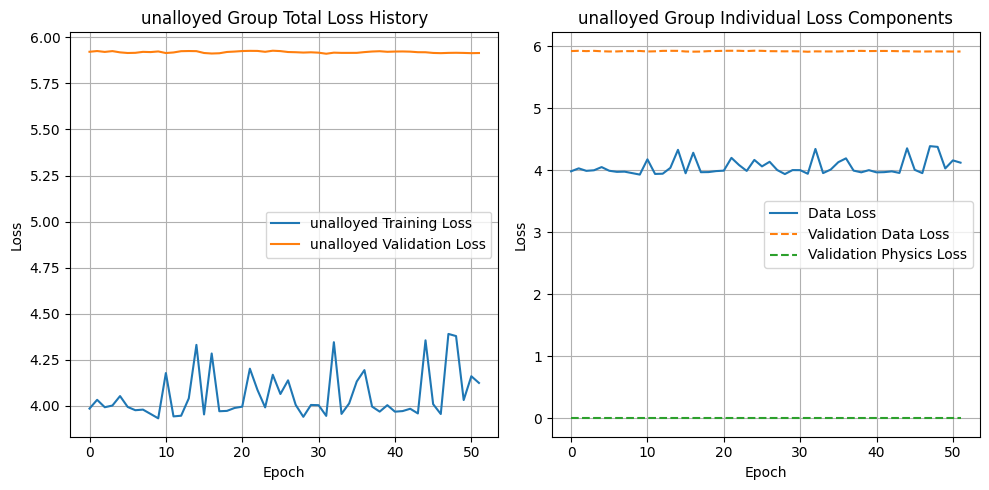


=== lowalloy 그룹 모델 학습 시작 ===
lowalloy 그룹 모델 생성 완료: 입력 크기=3, 출력 크기=4
DEBUG: epf_loss (weighted): 0.5202, original_epf_loss: 0.4974
DEBUG: epf_loss (weighted): 0.8786, original_epf_loss: 0.8401
DEBUG: epf_loss (weighted): 1.9184, original_epf_loss: 1.8343
DEBUG: epf_loss (weighted): 0.6990, original_epf_loss: 0.6683
DEBUG: epf_loss (weighted): 1.2889, original_epf_loss: 1.2324
DEBUG: epf_loss (weighted): 1.7036, original_epf_loss: 1.6290
lowalloy - 에폭 [1/200], 학습 손실: 4.2127 (데이터: 4.2127, 물리: 0.0000), 검증 손실: 5.7787 (데이터: 5.7787, 물리: 0.0000)
  lowalloy - 검증 손실 개선, 모델 저장됨
DEBUG: epf_loss (weighted): 0.7607, original_epf_loss: 0.7273
DEBUG: epf_loss (weighted): 0.7564, original_epf_loss: 0.7233
DEBUG: epf_loss (weighted): 0.6421, original_epf_loss: 0.6139
DEBUG: epf_loss (weighted): 0.3996, original_epf_loss: 0.3820
DEBUG: epf_loss (weighted): 3.5236, original_epf_loss: 3.3692
DEBUG: epf_loss (weighted): 1.7013, original_epf_loss: 1.6267
DEBUG: epf_loss (weighted): 1.2826, original_epf_loss

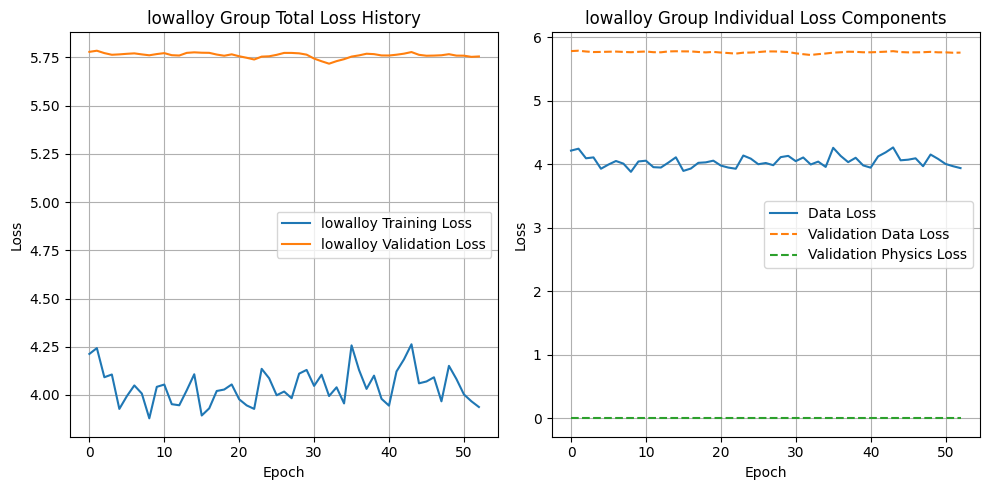


=== highalloy 그룹 모델 학습 시작 ===
highalloy 그룹 모델 생성 완료: 입력 크기=3, 출력 크기=4
DEBUG: epf_loss (weighted): 0.0204, original_epf_loss: 0.0195
DEBUG: epf_loss (weighted): 0.3130, original_epf_loss: 0.2993
DEBUG: epf_loss (weighted): 1.9077, original_epf_loss: 1.8241
DEBUG: epf_loss (weighted): 2.1195, original_epf_loss: 2.0266
DEBUG: epf_loss (weighted): 0.8959, original_epf_loss: 0.8567
DEBUG: epf_loss (weighted): 2.0896, original_epf_loss: 1.9980
highalloy - 에폭 [1/200], 학습 손실: 3.9291 (데이터: 3.9291, 물리: 0.0006), 검증 손실: 20.7146 (데이터: 20.7146, 물리: 0.0000)
  highalloy - 검증 손실 개선, 모델 저장됨
DEBUG: epf_loss (weighted): 0.2753, original_epf_loss: 0.2633
DEBUG: epf_loss (weighted): 1.4036, original_epf_loss: 1.3421
DEBUG: epf_loss (weighted): 0.4253, original_epf_loss: 0.4066
DEBUG: epf_loss (weighted): 2.3224, original_epf_loss: 2.2206
DEBUG: epf_loss (weighted): 0.1377, original_epf_loss: 0.1317
DEBUG: epf_loss (weighted): 2.0906, original_epf_loss: 1.9990
DEBUG: epf_loss (weighted): 0.7320, original_ep

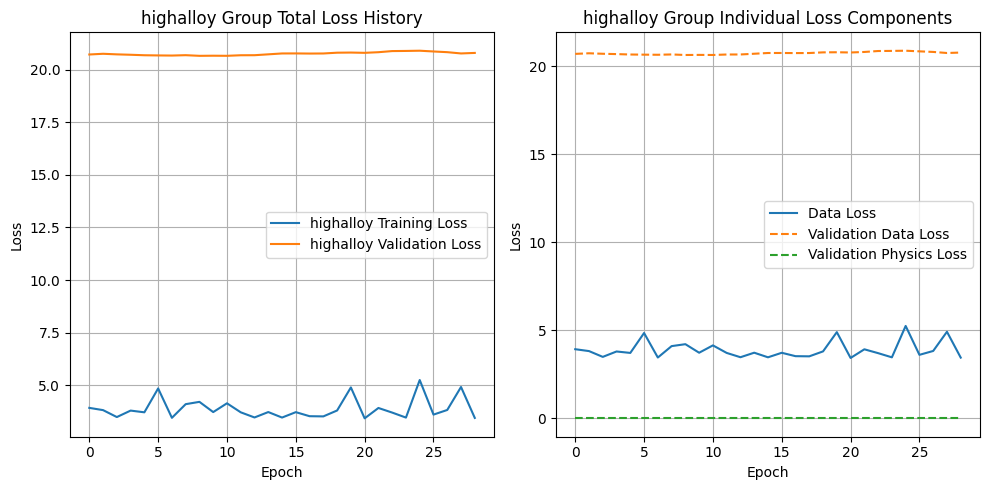


=== 모든 조성 그룹의 모델 학습 완료 ===
저장된 모델 파일:
  - model_unalloyed.pth
  - model_lowalloy.pth
  - model_highalloy.pth

총 3개 조성 그룹 학습 완료: ['unalloyed', 'lowalloy', 'highalloy']


In [31]:
# Cell 8: 그룹별 모델 학습 (조성 분류 기반으로 수정된 버전)

if len(df) > 0 and 'alloy_type' in df.columns:
    print("\n=== 조성 분류 기반 그룹별 개별 모델 학습 시작 ===")
    
    # 학습 하이퍼파라미터 (기존 최적화 결과 활용)
    learning_rate = 0.0014568233546356163
    epochs = 200
    patience = 20
    lambda_physics_value = 0.019082887574579432
    
    print(f"하이퍼파라미터: 에폭={epochs}, 학습률={learning_rate:.6f}, Lambda_Physics={lambda_physics_value:.6f}, 조기종료 인내={patience}")
    
    # 조성 기반 그룹별 모델 학습
    for group_name in ['unalloyed', 'lowalloy', 'highalloy']:
        # 해당 그룹의 데이터 로더가 존재하는지 확인
        train_loader_var = f'train_loader_{group_name}'
        val_loader_var = f'val_loader_{group_name}'
        scalers_y_var = f'scalers_y_{group_name}'
        
        if train_loader_var not in globals() or val_loader_var not in globals():
            print(f"\n{group_name} 그룹: 데이터 로더가 없어 건너뜁니다.")
            continue
            
        train_loader_g = globals()[train_loader_var]
        val_loader_g = globals()[val_loader_var]
        scalers_y_g = globals()[scalers_y_var]
        
        print(f"\n=== {group_name} 그룹 모델 학습 시작 ===")
        
        # 그룹별 모델 생성
        model_g = FatiguePINN(
            input_dim=len(feature_cols),
            output_dim=len(target_cols),
            hidden_dims=[192, 384, 352, 224],  # 옵투나 최적화 결과 적용
            dropout_p=0.35  # 옵투나 최적화 결과 적용
        ).to(device)
        
        print(f"{group_name} 그룹 모델 생성 완료: 입력 크기={len(feature_cols)}, 출력 크기={len(target_cols)}")
        
        # Optimizer
        optimizer_g = torch.optim.Adam(model_g.parameters(), lr=learning_rate)
        
        # Early stopping parameters
        best_val_loss_g = float('inf')
        epochs_no_improve_g = 0
        
        # Loss history
        train_loss_history_g = []
        val_loss_history_g = []
        train_data_loss_hist_g = []
        train_phys_loss_hist_g = []
        val_data_loss_hist_g = []
        val_phys_loss_hist_g = []
        
        # 학습 루프
        for epoch in range(epochs):
            model_g.train()
            train_epoch_loss = 0.0
            train_epoch_data_loss = 0.0
            train_epoch_phys_loss = 0.0
            
            for batch_X, batch_y_scaled, batch_E in train_loader_g:
                batch_X, batch_y_scaled, batch_E = batch_X.to(device), batch_y_scaled.to(device), batch_E.to(device)
                
                outputs_scaled = model_g(batch_X)
                loss, data_loss, phys_loss = pinn_loss_function(
                    outputs_scaled, batch_y_scaled, batch_E,
                    scalers_y_g, target_cols,
                    lambda_physics=lambda_physics_value, device=device
                )
                
                optimizer_g.zero_grad()
                loss.backward()
                optimizer_g.step()
                
                train_epoch_loss += loss.item()
                train_epoch_data_loss += data_loss.item()
                train_epoch_phys_loss += phys_loss.item() if not torch.isnan(phys_loss) else 0.0
            
            avg_train_loss = train_epoch_loss / len(train_loader_g)
            avg_train_data_loss = train_epoch_data_loss / len(train_loader_g)
            avg_train_phys_loss = train_epoch_phys_loss / len(train_loader_g)
            train_loss_history_g.append(avg_train_loss)
            train_data_loss_hist_g.append(avg_train_data_loss)
            train_phys_loss_hist_g.append(avg_train_phys_loss)
            
            # Validation phase
            model_g.eval()
            val_epoch_loss = 0.0
            val_epoch_data_loss = 0.0
            val_epoch_phys_loss = 0.0
            with torch.no_grad():
                for batch_X_val, batch_y_val_scaled, batch_E_val in val_loader_g:
                    batch_X_val, batch_y_val_scaled, batch_E_val = batch_X_val.to(device), batch_y_val_scaled.to(device), batch_E_val.to(device)
                    
                    outputs_val_scaled = model_g(batch_X_val)
                    val_loss, val_data_loss, val_phys_loss = pinn_loss_function(
                        outputs_val_scaled, batch_y_val_scaled, batch_E_val,
                        scalers_y_g, target_cols,
                        lambda_physics=lambda_physics_value, device=device
                    )
                    val_epoch_loss += val_loss.item()
                    val_epoch_data_loss += val_data_loss.item()
                    val_epoch_phys_loss += val_phys_loss.item() if not torch.isnan(val_phys_loss) else 0.0
            
            avg_val_loss = val_epoch_loss / len(val_loader_g)
            avg_val_data_loss = val_epoch_data_loss / len(val_loader_g)
            avg_val_phys_loss = val_epoch_phys_loss / len(val_loader_g)
            val_loss_history_g.append(avg_val_loss)
            val_data_loss_hist_g.append(avg_val_data_loss)
            val_phys_loss_hist_g.append(avg_val_phys_loss)
            
            # 진행 상황 출력 (매 20 에폭마다)
            if (epoch + 1) % 20 == 0 or epoch == 0:
                print(f"{group_name} - 에폭 [{epoch+1}/{epochs}], "
                      f"학습 손실: {avg_train_loss:.4f} (데이터: {avg_train_data_loss:.4f}, 물리: {avg_train_phys_loss:.4f}), "
                      f"검증 손실: {avg_val_loss:.4f} (데이터: {avg_val_data_loss:.4f}, 물리: {avg_val_phys_loss:.4f})")
            
            # Early stopping check
            if avg_val_loss < best_val_loss_g:
                best_val_loss_g = avg_val_loss
                epochs_no_improve_g = 0
                torch.save(model_g.state_dict(), f'model_{group_name}.pth')
                if (epoch + 1) % 20 == 0 or epoch == 0:
                    print(f"  {group_name} - 검증 손실 개선, 모델 저장됨")
            else:
                epochs_no_improve_g += 1
            
            if epochs_no_improve_g >= patience:
                print(f"  {group_name} - {epoch+1}번째 에폭에서 조기 종료")
                break
        
        print(f"{group_name} 그룹 학습 완료 - 최종 검증 손실: {best_val_loss_g:.4f}")
        
        # 그룹별 변수 저장
        globals()[f'model_{group_name}'] = model_g
        globals()[f'train_loss_history_{group_name}'] = train_loss_history_g
        globals()[f'val_loss_history_{group_name}'] = val_loss_history_g
        
        # 손실 그래프 그리기
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_loss_history_g, label=f'{group_name} Training Loss')
        plt.plot(val_loss_history_g, label=f'{group_name} Validation Loss')
        plt.title(f'{group_name} Group Total Loss History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(train_data_loss_hist_g, label='Data Loss')
        plt.plot(val_data_loss_hist_g, label='Validation Data Loss', linestyle='--')
        plt.plot(val_phys_loss_hist_g, label='Validation Physics Loss', linestyle='--')
        plt.title(f'{group_name} Group Individual Loss Components')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    print("\n=== 모든 조성 그룹의 모델 학습 완료 ===")
    print("저장된 모델 파일:")
    for group_name in ['unalloyed', 'lowalloy', 'highalloy']:
        if f'model_{group_name}' in globals():
            print(f"  - model_{group_name}.pth")

    # 그룹별 학습 완료 확인
    trained_groups = []
    for group_name in ['unalloyed', 'lowalloy', 'highalloy']:
        if f'model_{group_name}' in globals():
            trained_groups.append(group_name)

    if trained_groups:
        print(f"\n총 {len(trained_groups)}개 조성 그룹 학습 완료: {trained_groups}")
    else:
        print("\n경고: 어떤 그룹도 학습되지 않았습니다. Cell 6에서 데이터 준비가 제대로 되었는지 확인하세요.")

else:
    print("조성 분류 정보가 없거나 데이터가 없어 그룹별 학습을 건너뜁니다.")


In [32]:
# Cell 7: PINN 모델 정의 (FatiguePINN) - 옵투나 최적화 결과 적용 [192, 384, 352, 224] 구조

if len(df) > 0:
    class FatiguePINN(nn.Module):
        def __init__(self, input_dim, output_dim, hidden_dims=[192, 384, 352, 224], dropout_p=0.35): 
            super().__init__()
            self.input_dim = input_dim
            self.output_dim = output_dim

            layers = []
            last_dim = input_dim
            for hidden_dim in hidden_dims: # 인자로 받은 hidden_dims를 사용
                layers.append(nn.Linear(last_dim, hidden_dim))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout_p))  # 드롭아웃 레이어 추가
                last_dim = hidden_dim
            
            layers.append(nn.Linear(last_dim, output_dim)) # 최종 출력 레이어
            self.network = nn.Sequential(*layers)

        def forward(self, x):
            return self.network(x)

    # 모델 인스턴스화
    input_dim = X_train_scaled.shape[1] if 'X_train_scaled' in locals() else 4 
    output_dim = y_train_scaled.shape[1] if 'y_train_scaled' in locals() else 4 
    
    # --- 옵투나 최적화 결과 적용 ---
    hidden_dims_target = [192, 384, 352, 224] # 옵투나 최적화 결과 (4개 층)
    dropout_rate = 0.35  # 옵투나 최적화 결과
    
    # 모델 생성 시 hidden_dims_target와 dropout_p를 전달합니다.
    model = FatiguePINN(input_dim, output_dim, hidden_dims=hidden_dims_target, dropout_p=dropout_rate).to(device)

    print(f"PINN Model Definition (FatiguePINN with hidden_dims={hidden_dims_target}, dropout_p={dropout_rate}):")
    print(model) 

    # 더미 테스트
    try:
        batch_size_local = batch_size if 'batch_size' in locals() else 16
        dummy_input = torch.randn(batch_size_local, input_dim).to(device)
        dummy_output = model(dummy_input)
        print(f"\nDummy input shape: {dummy_input.shape}")
        print(f"Dummy output shape: {dummy_output.shape}")
    except Exception as e:
        print(f"\nCould not perform dummy test: {e}")
else:
    print("\nSkipping model definition as no data is available.")

PINN Model Definition (FatiguePINN with hidden_dims=[192, 384, 352, 224], dropout_p=0.35):
FatiguePINN(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=192, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.35, inplace=False)
    (3): Linear(in_features=192, out_features=384, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.35, inplace=False)
    (6): Linear(in_features=384, out_features=352, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.35, inplace=False)
    (9): Linear(in_features=352, out_features=224, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.35, inplace=False)
    (12): Linear(in_features=224, out_features=4, bias=True)
  )
)

Dummy input shape: torch.Size([4, 4])
Dummy output shape: torch.Size([4, 4])


전체 통합 결과 시각화 (기존 main0527과 동일한 형태)
총 테스트 샘플: 47개


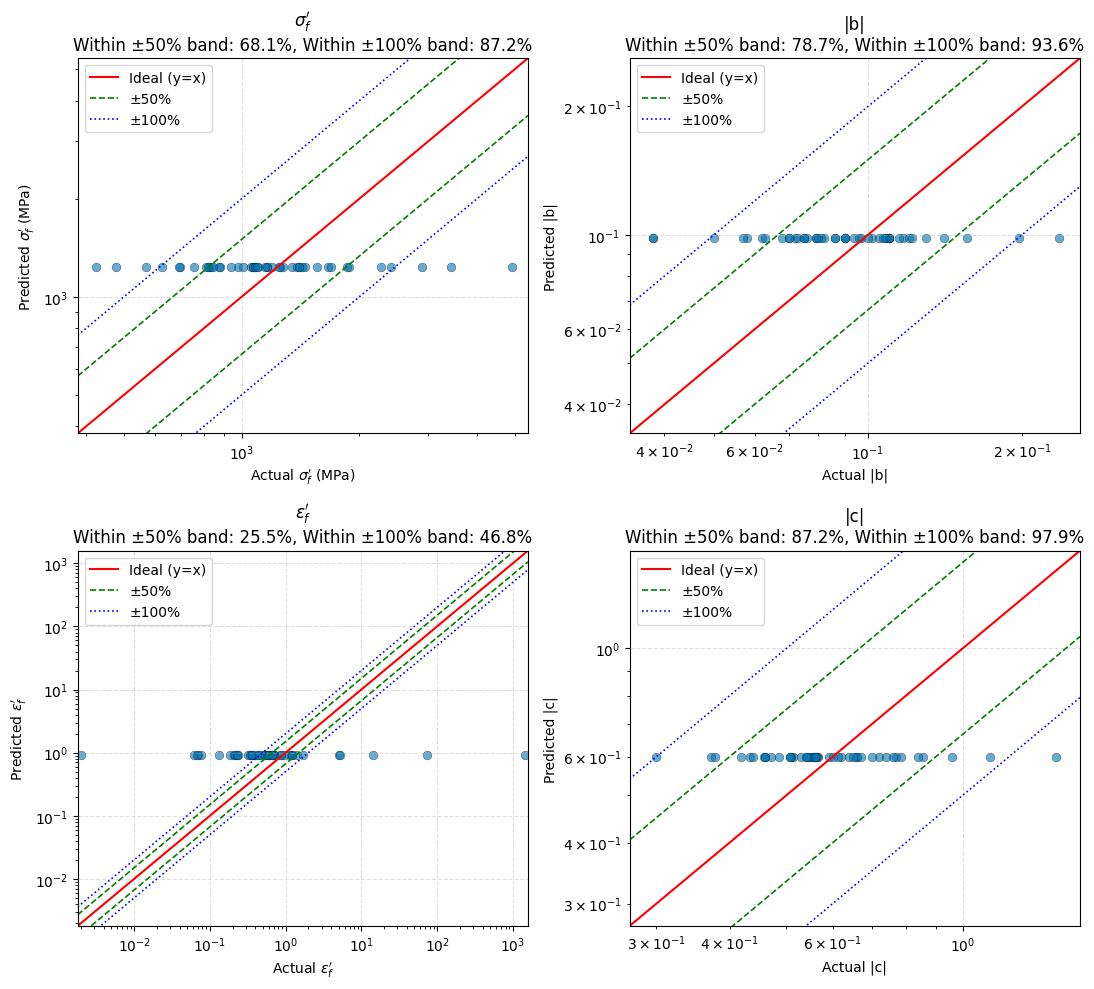

In [34]:
# Cell 13: 통합 결과 시각화 (기존 main0527과 동일한 형태)
# 그룹별 개별 학습 결과를 통합하여 기존과 동일한 scatter plot with error bands 표시

# 통합 결과가 있는지 확인
if 'all_preds_orig' in globals() and 'all_targets_orig' in globals():
    print("전체 통합 결과 시각화 (기존 main0527과 동일한 형태)")
    print(f"총 테스트 샘플: {all_preds_orig.shape[0]}개")
    
    # 색상 팔레트 정의
    import seaborn as sns
    palette = sns.color_palette("colorblind")
    
    # 2x2 그리드 생성
    fig, axes = plt.subplots(2, 2, figsize=(11, 10), facecolor='none')
    axes = axes.flatten()

    for i, param_name in enumerate(target_cols):
        param_pred = all_preds_orig[:, i]
        param_true = all_targets_orig[:, i]
        
        # b와 c 파라미터에 대해 절대값 사용
        if param_name == 'b' or param_name == 'c':
            param_pred = np.abs(param_pred)
            param_true = np.abs(param_true)
        
        # 오차 허용 밴드 계산
        ratio = param_pred / param_true
        inside_1p5 = np.logical_and(ratio >= 1/1.5, ratio <= 1.5).mean() * 100
        inside_2x = np.logical_and(ratio >= 0.5, ratio <= 2.0).mean() * 100

        min_val = min(param_pred.min(), param_true.min()) * 0.9
        max_val = max(param_pred.max(), param_true.max()) * 1.1
        
        if min_val <= 0:
            min_val = 1e-6
        
        line_vals = np.linspace(min_val, max_val, 100)

        # 산점도
        axes[i].scatter(param_true, param_pred, alpha=0.6, s=40, color=palette[0], edgecolor='k', linewidth=0.3)

        # 기준선 (y=x) 및 오차 허용 밴드
        axes[i].plot(line_vals, line_vals, 'r-', linewidth=1.5, label='Ideal (y=x)')
        
        # 1.5x error bands (±50% error)
        axes[i].plot(line_vals, line_vals * 1.5, 'g--', linewidth=1.2, label='±50%')
        axes[i].plot(line_vals, line_vals / 1.5, 'g--', linewidth=1.2)
        
        # 2x error bands (±100% error)
        axes[i].plot(line_vals, line_vals * 2.0, 'b:', linewidth=1.2, label='±100%')
        axes[i].plot(line_vals, line_vals * 0.5, 'b:', linewidth=1.2)

        axes[i].set_xscale('log')
        axes[i].set_yscale('log')

        # 레이블 및 제목 설정
        if param_name == 'b' or param_name == 'c':
            axes[i].set_xlabel(f'Actual |{param_name}|')
            axes[i].set_ylabel(f'Predicted |{param_name}|')
            axes[i].set_title(f'|{param_name}|\nWithin ±50% band: {inside_1p5:.1f}%, Within ±100% band: {inside_2x:.1f}%')
        elif param_name == 'spf_MPa':
            axes[i].set_xlabel(r'Actual $\sigma^{\prime}_f$ (MPa)')
            axes[i].set_ylabel(r'Predicted $\sigma^{\prime}_f$ (MPa)')
            axes[i].set_title(r'$\sigma^{\prime}_f$' + f'\nWithin ±50% band: {inside_1p5:.1f}%, Within ±100% band: {inside_2x:.1f}%')
        elif param_name == 'epf':
            axes[i].set_xlabel(r'Actual $\varepsilon^{\prime}_f$')
            axes[i].set_ylabel(r'Predicted $\varepsilon^{\prime}_f$')
            axes[i].set_title(r'$\varepsilon^{\prime}_f$' + f'\nWithin ±50% band: {inside_1p5:.1f}%, Within ±100% band: {inside_2x:.1f}%')
        else:
            axes[i].set_xlabel(f'Actual {param_name}')
            axes[i].set_ylabel(f'Predicted {param_name}')
            axes[i].set_title(f'{param_name}\nWithin ±50% band: {inside_1p5:.1f}%, Within ±100% band: {inside_2x:.1f}%')
        
        axes[i].set_xlim(min_val, max_val)
        axes[i].set_ylim(min_val, max_val)
        axes[i].legend(frameon=True, loc='upper left')
        axes[i].grid(True, linestyle='--', alpha=0.4)
        axes[i].set_facecolor('none')

    plt.tight_layout()
    plt.show()
    
else:
    print("통합 결과 데이터가 없습니다. 이전 셀들을 먼저 실행하세요.")


In [36]:
# Cell 16: 그룹별 피로 수명(2Nf) 비교 - Load Reversals Plot

from scipy.optimize import fsolve
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib as mpl

# --- 이전 셀들에서 정의된 변수 사용 가정 ---
# model, scaler_X, scalers_y (딕셔너리), target_cols (리스트)
# X_test_tensor, y_test_orig_tensor, E_test_tensor (Cell 6에서 생성)
# all_preds_orig, all_targets_orig (Cell 10에서 생성된 NumPy 배열)
# E_test_np (Cell 10에서 E_test_tensor.cpu().numpy().flatten()으로 생성 가능)
# inverse_transform_targets 함수 (Cell 6에서 정의)
# palette (Cell 10에서 정의)

# Times New Roman 폰트 설정 등 (Cell 10의 mpl.rcParams.update 복사)
mpl.rcParams.update({
    'font.family': 'serif', 'font.serif': 'Times New Roman', 'font.size': 12,
    'axes.labelsize': 20, 'axes.titlesize': 14, 'legend.fontsize': 10, # 범례 폰트 크기 조정
    'xtick.labelsize': 11, 'ytick.labelsize': 11, 'lines.linewidth': 1.8,
    'axes.grid': True, 'grid.alpha': 0.3, 'figure.dpi': 300,
    'axes.unicode_minus': False
})

# --- 1. 평가를 위한 변형률 진폭(Δε/2) 값 정의 (논문 참조) ---
defined_total_strain_amplitudes = np.array([
    0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.009, 0.015
])
print(f"평가를 위해 사용할 고정된 총 변형률 진폭 (Δε/2 또는 ε_a) 값들: {defined_total_strain_amplitudes}")


def solve_2Nf_from_strain(params, E_val, epsilon_a_target):
    spf, b_exp, epf, c_exp = params
    E_val_safe = max(float(E_val), 1e-9)

    def equation(two_Nf_val_log10):
        two_Nf_val = 10**two_Nf_val_log10
        if two_Nf_val <= 0: return float('inf')
        try:
            term1 = (spf / E_val_safe) * np.power(max(two_Nf_val, 1e-9), b_exp)
            term2 = epf * np.power(max(two_Nf_val, 1e-9), c_exp)
            return term1 + term2 - epsilon_a_target
        except OverflowError: return float('inf')
        except ValueError: return float('inf')

    initial_guess_log10 = 4.0
    if epsilon_a_target > 0.01: initial_guess_log10 = 2.0
    elif epsilon_a_target < 0.002: initial_guess_log10 = 5.0

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        solution_log10, infodict, ier, mesg = fsolve(equation, initial_guess_log10, full_output=True, xtol=1e-7, maxfev=500)
    
    if ier == 1 and isinstance(solution_log10, (np.ndarray, list)) and len(solution_log10) > 0:
        return 10**solution_log10[0]
    elif ier == 1 and isinstance(solution_log10, (int, float)):
         return 10**solution_log10
    else:
        return np.nan

# --- 2. 그룹별 데이터 준비 및 2Nf 계산 ---
print("\n=== 그룹별 Load Reversals (2Nf) 비교 ===")

# 그룹별로 개별 분석
for group_name in ['unalloyed', 'lowalloy', 'highalloy']:
    if f'all_preds_orig_{group_name}' in globals() and f'all_targets_orig_{group_name}' in globals():
        
        predicted_params_group = globals()[f'all_preds_orig_{group_name}']
        true_params_group = globals()[f'all_targets_orig_{group_name}']
        E_values_group = globals()[f'E_test_{group_name}'] if f'E_test_{group_name}' in globals() else []
        
        print(f"\n=== {group_name} 그룹 2Nf 분석 ===")
        print(f"샘플 수: {len(predicted_params_group)}")
        
        if len(E_values_group) == 0:
            print(f"{group_name} 그룹의 E 값이 없어 건너뜁니다.")
            continue

        try:
            spf_idx = target_cols.index('spf_MPa')
            b_idx = target_cols.index('b')
            epf_idx = target_cols.index('epf')
            c_idx = target_cols.index('c')
        except ValueError as e:
            print(f"오류: target_cols 리스트에 필요한 파라미터 이름이 없습니다: {e}")
            continue

        # --- 3. 그룹별 2Nf_exp 및 2Nf_est 계산 ---
        twoNf_exp_collected_group = []
        twoNf_est_collected_group = []
        
        num_test_samples_group = len(true_params_group)
        print(f"  {group_name}: {num_test_samples_group}개 샘플, {len(defined_total_strain_amplitudes)}개 변형률 레벨")

        for i in range(num_test_samples_group):
            params_true_sample = true_params_group[i, :]
            params_pred_sample = predicted_params_group[i, :]
            E_val_sample_i = E_values_group[i]

            if any(np.isnan(params_true_sample)) or any(np.isnan(params_pred_sample)):
                continue
                
            for strain_amplitude_level in defined_total_strain_amplitudes:
                twoNf_exp = solve_2Nf_from_strain(params_true_sample, E_val_sample_i, strain_amplitude_level)
                twoNf_est = solve_2Nf_from_strain(params_pred_sample, E_val_sample_i, strain_amplitude_level)

                if not np.isnan(twoNf_exp) and not np.isnan(twoNf_est) and \
                   twoNf_exp > 0 and twoNf_est > 0:
                    if 10**1 <= twoNf_exp <= 10**7 :
                        twoNf_exp_collected_group.append(twoNf_exp)
                        twoNf_est_collected_group.append(twoNf_est)

        if len(twoNf_exp_collected_group) == 0:
            print(f"  {group_name}: 유효한 2Nf 데이터 포인트가 없어 건너뜁니다.")
            continue
            
        log_2Nf_exp_group = np.log10(np.array(twoNf_exp_collected_group))
        log_2Nf_est_group = np.log10(np.array(twoNf_est_collected_group))

        print(f"  {group_name}: {len(log_2Nf_exp_group)}개 유효 (2Nf_exp, 2Nf_est) 쌍 생성")
    
        # --- 4. 그룹별 산점도 (Scatter Plot) 작성 ---
        plt.figure(figsize=(8, 7), facecolor='none')
        
        r2_2Nf_group = r2_score(log_2Nf_exp_group, log_2Nf_est_group)
        
        # --- Scatter band inclusion rate 계산 (2x, 3x, 5x) ---
        ratio_2Nf_group = np.array(twoNf_est_collected_group) / np.array(twoNf_exp_collected_group)
        inside_2x_2Nf_group = np.logical_and(ratio_2Nf_group >= 1/2, ratio_2Nf_group <= 2).mean() * 100
        inside_3x_2Nf_group = np.logical_and(ratio_2Nf_group >= 1/3, ratio_2Nf_group <= 3).mean() * 100
        inside_5x_2Nf_group = np.logical_and(ratio_2Nf_group >= 1/5, ratio_2Nf_group <= 5).mean() * 100
        
        plot_axis_min_log = 1.0
        plot_axis_max_log = 7.0
        line_vals_log = np.linspace(plot_axis_min_log, plot_axis_max_log, 100)

        # 그룹별 색상 사용
        group_colors = {'unalloyed': '#1f77b4', 'lowalloy': '#ff7f0e', 'highalloy': '#2ca02c'}
        scatter_color = group_colors.get(group_name, 'blue')

        plt.scatter(log_2Nf_exp_group, log_2Nf_est_group, alpha=0.6, s=40, 
                    color=scatter_color, edgecolor='k', linewidth=0.2)
        
        plt.plot(line_vals_log, line_vals_log, 'r-', linewidth=1.5, label='Ideal (y=x)')
        
        # --- Scatter band 플롯 (2x, 3x, 5x) ---
        log_factor_2 = np.log10(2.0)
        log_factor_3 = np.log10(3.0)
        log_factor_5 = np.log10(5.0)
        
        # 2x Band
        plt.plot(line_vals_log, line_vals_log + log_factor_2, color='darkorange', linestyle='--', linewidth=1.2, label='±2x Band')
        plt.plot(line_vals_log, line_vals_log - log_factor_2, color='darkorange', linestyle='--', linewidth=1.2)
        
        # 3x Band
        plt.plot(line_vals_log, line_vals_log + log_factor_3, color='green', linestyle=':', linewidth=1.2, label='±3x Band')
        plt.plot(line_vals_log, line_vals_log - log_factor_3, color='green', linestyle=':', linewidth=1.2)
        
        # 5x Band
        plt.plot(line_vals_log, line_vals_log + log_factor_5, color='purple', linestyle='-.', linewidth=1.2, label='±5x Band')
        plt.plot(line_vals_log, line_vals_log - log_factor_5, color='purple', linestyle='-.', linewidth=1.2)

        plt.xlabel('Load Reversals(experimental), Log(2N$_{f,exp}$)')
        plt.ylabel('Load Reversals(estimated), Log(2N$_{f,est}$)')
        
        # --- 그룹별 제목 ---
        title_text = (f'{group_name} Group - Fatigue Life (2Nf) Prediction\n'
                      f'R² = {r2_2Nf_group:.3f}, Samples = {len(log_2Nf_exp_group)}\n'
                      f'Within ±2x: {inside_2x_2Nf_group:.1f}%, ±3x: {inside_3x_2Nf_group:.1f}%, ±5x: {inside_5x_2Nf_group:.1f}%')
        plt.title(title_text)
        
        plt.xlim(plot_axis_min_log - 0.2, plot_axis_max_log + 0.2)
        plt.ylim(plot_axis_min_log - 0.2, plot_axis_max_log + 0.2)
        
        tick_values = np.arange(int(np.floor(plot_axis_min_log)), int(np.ceil(plot_axis_max_log)) + 1, 1.0)
        plt.xticks(tick_values)
        plt.yticks(tick_values)
        
        plt.legend(frameon=True, loc='upper left', fontsize=9)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.gca().set_facecolor('none')

        plt.tight_layout()
        plt.show()
        
        print(f"  {group_name} - R² = {r2_2Nf_group:.4f}")
        print(f"  {group_name} - ±2x: {inside_2x_2Nf_group:.1f}%, ±3x: {inside_3x_2Nf_group:.1f}%, ±5x: {inside_5x_2Nf_group:.1f}%")

print("\n=== 모든 그룹의 Load Reversals 분석 완료 ===")

평가를 위해 사용할 고정된 총 변형률 진폭 (Δε/2 또는 ε_a) 값들: [0.0025 0.003  0.0035 0.004  0.0045 0.005  0.009  0.015 ]

=== 그룹별 Load Reversals (2Nf) 비교 ===

=== 모든 그룹의 Load Reversals 분석 완료 ===
